# Fraud Detection - EDA I

# Summary

**Vesta Corporation**, leader dans la gestion des transactions en ligne, cherche à renforcer ses capacités de **détection des fraudes** électroniques. Face aux enjeux critiques que représentent les fraudes - pertes financières et perte de confiance des clients - l’entreprise vise à développer un modèle de machine learning performant, capable de distinguer les transactions frauduleuses des transactions légitimes.
Pour cela, une étape clé consiste à exploiter pleinement les données disponibles à travers une **analyse exploratoire** approfondie et un travail rigoureux de **feature engineering**. Ce dernier permet d’extraire des variables pertinentes à partir des informations transactionnelles, comportementales et techniques (appareils, navigateurs, etc.), dans le but d’améliorer la capacité prédictive du modèle et de mieux capturer les signaux faibles liés à la fraude.

## Packages 

In [1]:
#!pip install imbalanced-learn
#!pip install pendulum
#!pip install loguru

In [2]:
from pathlib import Path
import re
import altair as alt
import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from yellowbrick.classifier import DiscriminationThreshold
from ydata_profiling import ProfileReport

set_config(display='diagram')
pd.set_option("display.max_columns", None)

In [3]:
import os

# Remonter d'un niveau (depuis C:\Users\Hania) et aller dans le bon dossier
os.chdir(r"C:\Users\Hania\Desktop\ISE2\2eme semestre\Machine learning 2\Fraud Detection\projet fraud_detection")

# Vérifier le répertoire courant
print(os.getcwd())


C:\Users\Hania\Desktop\ISE2\2eme semestre\Machine learning 2\Fraud Detection\projet fraud_detection


## I. Chargement et fusion des données 

In [4]:
import pandas as pd
# Chargement des données
#train_transaction = pd.read_csv("data/train_transaction.csv")
#train_identity = pd.read_csv("data/train_identity.csv") 

In [5]:
# Conversion et export au format Parquet
#train_transaction.to_parquet("data/train_transaction.parquet", engine="pyarrow", index=False)
#train_identity.to_parquet("data/train_identity.parquet", engine="pyarrow", index=False)

In [6]:
# Lecture des fichiers Parquet
train_transaction_parquet = pd.read_parquet("data/train_transaction.parquet", engine="pyarrow")
train_identity_parquet = pd.read_parquet("data/train_identity.parquet", engine="pyarrow")

### 1. Caractéristiques des données 

In [7]:
# dimensionnalité des données 
print("Train Transaction:", train_transaction_parquet.shape)
print("Train Identity:", train_identity_parquet.shape)

Train Transaction: (590540, 394)
Train Identity: (144233, 41)


In [8]:
train_transaction_parquet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [9]:
train_identity_parquet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

Les datasets train_transaction et train_identity contiennent chacune respectivement 590540 et 144233 lignes et 394 et 41 lignes.
Elles possèdent des données de type entier, réels... 

###  Aperçu des données

In [10]:
train_identity_parquet.head(3)

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN  None    NaN    NaN    NaN  None    New   
1  621.0  500.0    NaN    NaN  None    NaN    NaN    NaN  None    New   
2  410.0  142.0    NaN    NaN  None    NaN    NaN    NaN  None  Found   

      id_29        id_30                id_31  id_32      id_33  \
0  NotFound  Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound   iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found         None          chrome 62.0    NaN       None   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2            None     F     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows

In [11]:
train_transaction_parquet.head(5)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0          None          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com          None  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15    M1    M2    M3    M4    M5    M6  \
0  13.0   13.0  NaN  NaN  NaN    0.0     T     T     T    M2     F     T   
1   0.0    NaN  NaN  NaN  NaN    0.0  None  None  None    M0     T     T   
2   0.0  315.0  NaN  NaN  NaN  315.0     T     T     T    M0     F     F   
3  84.0    NaN  NaN  NaN  NaN  111.0  None  None  None    M0     T     F   
4   NaN    NaN  NaN  NaN  NaN    NaN  None  None  None  None  None  None   

     M7    M8    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  \
0  None  None  None  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
1  None  None  None  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2     F     F     F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
3  None  None  None  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  None  None  None  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  \
0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
2  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
3  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
2  0.0  0.0  1.0  1.0  1.0  1

## 2. Fusion des données

Explication :

- **train_transaction** contient toutes les transactions et **train_identity** contient des informations comportementales et techniques (device, IP, etc.) uniquement pour certaines transactions (souvent celles suspectes ou plus importantes).
- Il faut donc fusionner **train_transaction** avec **train_identity** pour rassembler toutes les informations (financières + comportementales) sur chaque transaction dans un seul tableau. La clé commune entre les deux est : TransactionID. Cela permet de faire une analyse complète et de construire un modèle plus performant.
- Pour ce faire on va procéder à une jointure à gauche (left join) pour conserver toutes les lignes de **train_transaction** et ajouter les colonnes de **train_identity** si elles existent. 

In [12]:
train = train_transaction_parquet.merge(train_identity_parquet, on='TransactionID', how='left')

In [13]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0          None          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com          None  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com          None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15    M1    M2    M3    M4    M5    M6  \
0  13.0   13.0  NaN  NaN  NaN    0.0     T     T     T    M2     F     T   
1   0.0    NaN  NaN  NaN  NaN    0.0  None  None  None    M0     T     T   
2   0.0  315.0  NaN  NaN  NaN  315.0     T     T     T    M0     F     F   
3  84.0    NaN  NaN  NaN  NaN  111.0  None  None  None    M0     T     F   
4   NaN    NaN  NaN  NaN  NaN    NaN  None  None  None  None  None  None   

     M7    M8    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  \
0  None  None  None  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
1  None  None  None  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2     F     F     F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
3  None  None  None  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  None  None  None  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  \
0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
2  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
3  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
2  0.0  0.0  1.0  1.0  1.0  1

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [15]:
train_1 = train

### Séparation du train et du test 

In [16]:
from sklearn.model_selection import train_test_split

X = train_1.drop(columns=["isFraud"])
y = train_1["isFraud"]

# Séparation en 80% train et 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
train1 = pd.concat([X_train, y_train], axis=1)

In [18]:
test1 = pd.concat([X_test, y_test], axis=1)

In [19]:
test1.to_csv("test_fin.csv", index=False)

In [20]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472432 entries, 40809 to 337290
Columns: 434 entries, TransactionID to isFraud
dtypes: float64(399), int64(4), object(31)
memory usage: 1.5+ GB


In [21]:
X_test.shape

(118108, 433)

In [22]:
X_train.shape

(472432, 433)

Notre jeu de données d'entrainement contient 472432 lignes. 

In [23]:
train1.head(5)

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
40809         3027809        1008491          100.00         R   6177  399.0   
285886        3272886        7008212           29.99         W   7900  345.0   
104256        3091256        2071522          107.95         W  11690  111.0   
507860        3494860       13299752          241.95         W   2616  327.0   
196382        3183382        4412283          117.00         W  13780  298.0   

        card3             card4  card5   card6  addr1  addr2  dist1  dist2  \
40809   150.0  american express  150.0  credit  264.0   87.0    NaN    1.0   
285886  150.0        mastercard  224.0   debit  143.0   87.0    4.0    NaN   
104256  150.0              visa  226.0  credit  191.0   87.0    NaN    NaN   
507860  150.0          discover  102.0  credit  330.0   87.0    3.0    NaN   
196382  150.0              visa  226.0   debit  441.0   87.0    5.0    NaN   

        P_emaildomain  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8  \
40809   anonymous.com  anonymous.com  1.0  1.0  0.0  2.0  0.0  1.0  0.0  2.0   
285886      gmail.com           None  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
104256    comcast.net           None  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   
507860           None           None  1.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0   
196382           None           None  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

         C9  C10  C11  C12   C13  C14     D1     D2    D3     D4    D5  D6  \
40809   0.0  2.0  1.0  0.0   2.0  1.0  609.0  609.0   NaN    NaN   NaN NaN   
285886  1.0  0.0  1.0  0.0   0.0  0.0    0.0    NaN   NaN    0.0   NaN NaN   
104256  1.0  0.0  1.0  0.0  15.0  1.0  501.0  501.0  18.0  502.0  18.0 NaN   
507860  1.0  0.0  1.0  0.0   4.0  1.0  177.0  177.0  86.0    NaN   NaN NaN   
196382  1.0  0.0  1.0  0.0   2.0  1.0    0.0    0.0   0.0    NaN   NaN NaN   

        D7          D8        D9    D10    D11  D12  D13  D14    D15    M1  \
40809  NaN  609.666687  0.666666    NaN    NaN  NaN  NaN  NaN    NaN  None   
285886 NaN         NaN       NaN    0.0    0.0  NaN  NaN  NaN    0.0     T   
104256 NaN         NaN       NaN  502.0    NaN  NaN  NaN  NaN  502.0  None   
507860 NaN         NaN       NaN  177.0  177.0  NaN  NaN  NaN  177.0     T   
196382 NaN         NaN       NaN    0.0    0.0  NaN  NaN  NaN    0.0     T   

          M2    M3    M4    M5    M6    M7    M8    M9   V1   V2   V3   V4  \
40809   None  None  None  None  None  None  None  None  NaN  NaN  NaN  NaN   
285886     T     T    M0     T     F     F     F     T  1.0  1.0  1.0  1.0   
104256  None  None  None  None     T  None  None  None  NaN  NaN  NaN  NaN   
507860     T     F  None  None     T     F     F     T  1.0  1.0  1.0  0.0   
196382     T     T    M0     T     F  None  None  None  1.0  1.0  1.0  0.0   

         V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
40809   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
285886  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
104256  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
507860  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
196382  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

        V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  \
40809   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
285886  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
104256  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   
507860  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   
196382  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

        V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  \
40809   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
285886  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  

##  II. Analyse Exploratoire des données 

### 1. Analyse de la variable cible : isFraud

In [24]:
# Count the occurrences of fraud and no fraud and print them
occ = train1['isFraud'].value_counts()
occ

isFraud
0    455902
1     16530
Name: count, dtype: int64

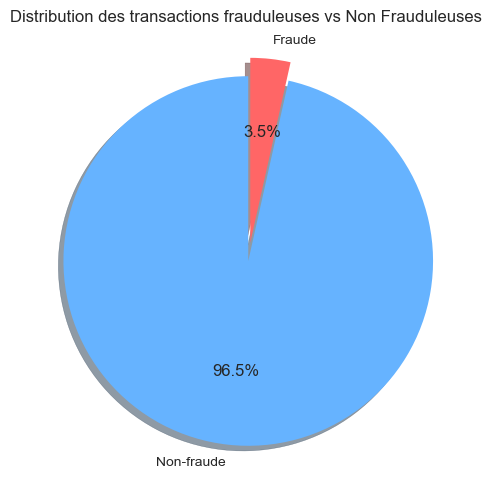

In [25]:
labels = ['Non-fraude', 'Fraude']
# Créer le diagramme circulaire
plt.figure(figsize=(6, 6))
plt.pie(occ, labels=labels, autopct='%1.1f%%', startangle=90, colors = ['#66b3ff', '#ff6666'], explode=(0, 0.1), shadow=True)
plt.title('Distribution des transactions frauduleuses vs Non Frauduleuses ')
plt.show()


3,5 % des transactions sont frauduleuses.
Notre jeu de données initial est très déséquilibré !
La majorité des transactions ne sont pas frauduleuses.

### 2. Analyse des variables explicatives 

In [26]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472432 entries, 40809 to 337290
Columns: 434 entries, TransactionID to isFraud
dtypes: float64(399), int64(4), object(31)
memory usage: 1.5+ GB


Nous avons des variables de type catégorielle et de type numérique

#### 2.1 Detection et gestion de valeurs manquantes 

<Axes: >

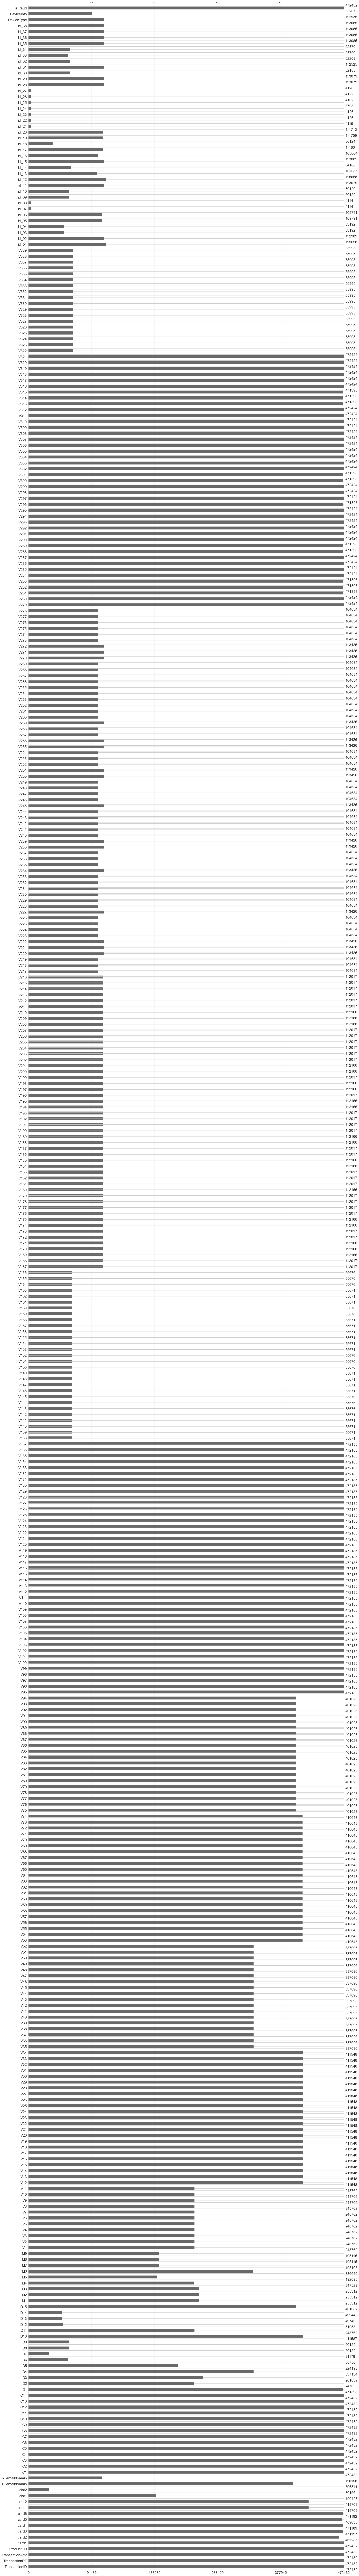

In [27]:
msno.bar(train1)

In [28]:
data_null = train1.isnull().sum() / len(train1) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)
print(data_null.head())

id_24    99.197133
id_25    99.131727
id_07    99.129187
id_08    99.129187
id_21    99.128128
dtype: float64


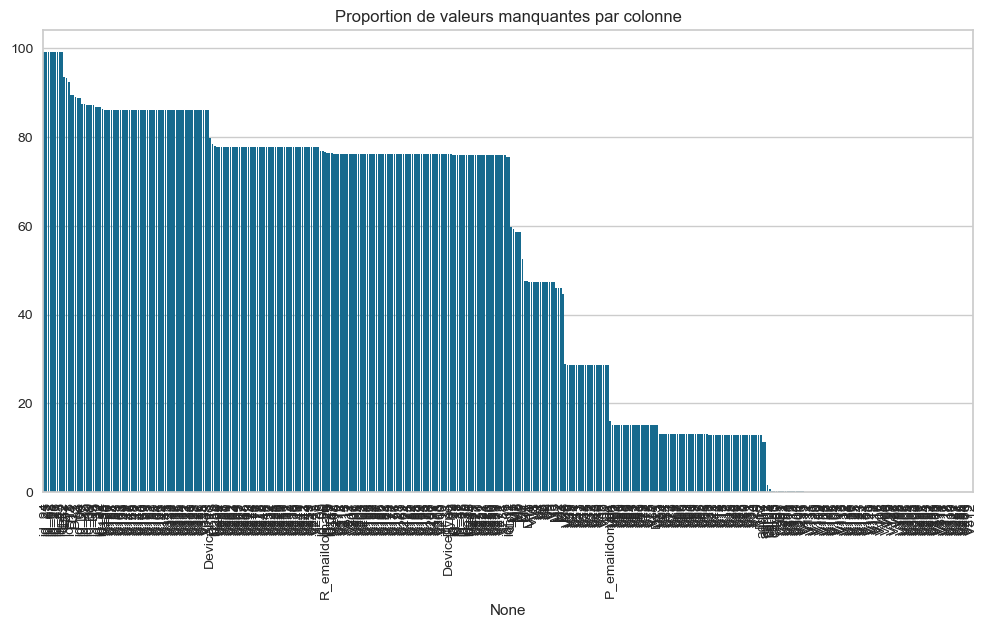

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(x=data_null.index, y=data_null.values)
plt.xticks(rotation=90)
plt.title("Proportion de valeurs manquantes par colonne")
plt.show()

Certaines colonnes de notre dataset ont plus de 99% de valeurs manquantes; ces dernières ne nous apportent pas beaucoup d'informations et peuvent être supprimées. De manière générale nous allons procéder à la suppression des colonnes contenant plus de 90% de NA car effectuer une imputation risque de biaiser la classification. 

#### 2.2 Suppression des valeurs variables avec un pourcentage élévé de valeurs manquantes

In [30]:
# Seuils
seuil_id = 0.90
seuil_autres = 0.80

# Calcul du taux de valeurs manquantes
na_ratio = train1.isnull().sum() / len(train1)

# Colonnes commençant par "id_"
id_cols = [col for col in train1.columns if col.startswith("id_")]
other_cols = [col for col in train1.columns if col not in id_cols]

# Sélection des colonnes à supprimer selon les seuils
many_null_id_cols = [col for col in id_cols if na_ratio[col] > seuil_id]
many_null_other_cols = [col for col in other_cols if na_ratio[col] > seuil_autres]

# Fusion
many_null_cols = many_null_id_cols + many_null_other_cols

# Affichage
print(f"{len(many_null_cols)} colonnes ont dépassé les seuils de valeurs manquantes.")
print(f"{len(many_null_id_cols)} colonnes 'id_' dépassent {seuil_id*100}% de NA.")
print(f"{len(many_null_other_cols)} autres colonnes dépassent {seuil_autres*100}% de NA.")


65 colonnes ont dépassé les seuils de valeurs manquantes.
10 colonnes 'id_' dépassent 90.0% de NA.
55 autres colonnes dépassent 80.0% de NA.


In [31]:
quasi_const_cols = []
seuil_const = 0.95

for col in train1.columns:
    if col == 'isFraud':
        continue
    top_freq = train1[col].value_counts(normalize=True, dropna=False).values[0]
    if top_freq >= seuil_const:
        quasi_const_cols.append(col)

print(f"{len(quasi_const_cols)} colonnes quasi-constantes détectées.")


36 colonnes quasi-constantes détectées.


In [32]:
one_value_cols = [col for col in train1.columns if train1[col].nunique() == 1]
print(f"{len(one_value_cols)} colonnes avec une seule modalité.")

0 colonnes avec une seule modalité.


Nous adoptons une première stratégie de traitement des valeurs manquantes qui consiste à supprimer les variables ayant une seule modalité, plus de 85% de valeurs manquantes ou une modalité trop dominante (>95 %). Ces variables apportent peu ou pas d'information pertinente au modèle. Leur retrait permet d'améliorer la qualité, la lisibilité et la performance de l’analyse. Pour cela nous allons visualiser 

In [33]:
# Séparer les colonnes "id_" et les autres
id_cols = [col for col in train1.columns if col.startswith("id_")]
other_cols = [col for col in train1.columns if col not in id_cols]

# Colonnes avec une seule modalité
one_value_cols = [col for col in train1.columns if train1[col].nunique() == 1]

# Colonnes avec trop de valeurs manquantes selon le seuil adapté
na_ratio = train1.isnull().sum() / len(train1)
many_null_id_cols = [col for col in id_cols if na_ratio[col] > 0.90]
many_null_other_cols = [col for col in other_cols if na_ratio[col] > 0.80]

# Colonnes dont la modalité principale domine trop
big_top_value_cols = [col for col in train1.columns 
                      if train1[col].value_counts(dropna=False, normalize=True).values[0] > 0.90]

# Fusion de toutes les colonnes à supprimer
cols_to_drop = list(set(one_value_cols + many_null_id_cols + many_null_other_cols + big_top_value_cols))

# Ne jamais supprimer la variable cible
if 'isFraud' in cols_to_drop:
    cols_to_drop.remove('isFraud')

# Suppression dans le train uniquement
train1 = train1.drop(columns=cols_to_drop)

# Résumé
print(f"{len(cols_to_drop)} colonnes supprimées du train car jugées non informatives.")



119 colonnes supprimées du train car jugées non informatives.


In [34]:
print(train1.shape)


(472432, 315)


Par la suite nous allons analyser les variables groupe par groupe ou une à une en faisant un traitement des valeurs manquantes si possible, une création de nouvelles features 

### 2.3 Analyse des variables catégorielles

Nous commençons par définir des fonctions qui nous faciliteront les descriptions et visualisations des variables 

#### Fonction de visualisation et de description 

In [35]:
# Visualisation : cette fonction permet de donner la distribution d'une variable ainsi le taux de fraude pour chaque modalité
def labels(ax, df, xytext=(0, 0)):
    for bar in ax.patches: 
        ax.annotate('%{:.2f}\n{:.0f}'.format(100*bar.get_height()/len(df), bar.get_height()), 
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    ha='center', va='center', 
                    size=11, xytext=xytext, 
                    textcoords='offset points')

def plot_col(col, df, figsize=(20,6)):
    colors_fraud = ['#1f77b4', 'yellow']  # Bleu pour non fraude, orange pour fraude
    point_color = '#2ca02c'  # Vert pour le pointplot

    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)

    plt.subplot(121)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df, hue='isFraud', 
                         order=np.sort(df[col].dropna().unique()),
                         palette=colors_fraud)
    ax[0].tick_params(axis='x', rotation=90)
    labels(ax[0], df[col].dropna(), (0, 0))

    ax_twin = ax[0].twinx()
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color=point_color, legend=False, 
                           order=np.sort(df[col].dropna().unique()), linewidth=0.1)

    ax[0].grid()

    plt.subplot(122)
    ax[1] = sns.countplot(x=df[col].dropna(),
                         order=np.sort(df[col].dropna().unique()),
                         color='darkgreen')  # gris pour le second plot
    ax[1].tick_params(axis='x', rotation=90)
    labels(ax[1], df[col].dropna())

    plt.show()


In [36]:
# Description : cette fonction donne pour une variable , ses différentes modalités, ses valeurs manquantes 
def desc_col(expr, df):
    # Filtrer les colonnes qui correspondent à l'expression régulière
    columns = [col for col in df.columns if re.search(expr, col)]

    print('Description des colonnes :\nfeature: dtype, valeurs uniques, taux de valeurs manquantes (%)\n')

    for col in columns:
        dtype = df[col].dtype
        nunique = df[col].nunique()
        null_rate = round(df[col].isna().mean() * 100, 2)
        uniques = pd.Series(df[col].unique()).sort_values().values

        print(f'{col}: {dtype}, {nunique} valeurs uniques, {null_rate}% de valeurs manquantes')
        print(f'Valeurs uniques : {uniques}\n')


**Liste des variables catégorielles**

In [37]:
categorical_vars = train1.select_dtypes(include="object").columns
categorical_vars

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35',
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype='object')

In [38]:
train1[categorical_vars].head(5)

ProductCD             card4   card6  P_emaildomain  R_emaildomain  \
40809          R  american express  credit  anonymous.com  anonymous.com   
285886         W        mastercard   debit      gmail.com           None   
104256         W              visa  credit    comcast.net           None   
507860         W          discover  credit           None           None   
196382         W              visa   debit           None           None   

          M1    M2    M3    M4    M5    M6    M7    M8    M9     id_12  id_15  \
40809   None  None  None  None  None  None  None  None  None  NotFound  Found   
285886     T     T     T    M0     T     F     F     F     T       NaN    NaN   
104256  None  None  None  None  None     T  None  None  None       NaN    NaN   
507860     T     T     F  None  None     T     F     F     T       NaN    NaN   
196382     T     T     T    M0     T     F  None  None  None       NaN    NaN   

        id_16  id_28  id_29      id_30                id_31      id_33  \
40809   Found  Found  Found  Windows 7  ie 11.0 for desktop  1920x1080   
285886    NaN    NaN    NaN        NaN                  NaN        NaN   
104256    NaN    NaN    NaN        NaN                  NaN        NaN   
507860    NaN    NaN    NaN        NaN                  NaN        NaN   
196382    NaN    NaN    NaN        NaN                  NaN        NaN   

                 id_34 id_35 id_36 id_37 id_38 DeviceType   DeviceInfo  
40809   match_status:2     T     F     T     T    desktop  Trident/7.0  
285886             NaN   NaN   NaN   NaN   NaN        NaN          NaN  
104256             NaN   NaN   NaN   NaN   NaN        NaN          NaN  
507860             NaN   NaN   NaN   NaN   NaN        NaN          NaN  
196382             NaN   NaN   NaN   NaN   NaN        NaN          NaN

**Aperçu des valeurs manquantes des variables catégorielles**

Taux de valeurs manquantes :
id_33            0.875559
id_30            0.868377
id_34            0.867981
DeviceInfo       0.798475
id_16            0.780574
R_emaildomain    0.766747
id_31            0.761818
DeviceType       0.760950
id_29            0.760645
id_28            0.760645
id_15            0.760632
id_38            0.760632
id_37            0.760632
id_36            0.760632
id_35            0.760632
id_12            0.755186
M5               0.593391
M7               0.587020
M9               0.586999
M8               0.586999
M4               0.476054
M3               0.459579
M2               0.459579
M1               0.459579
M6               0.287432
P_emaildomain    0.160004
card4            0.002631
card6            0.002625
ProductCD        0.000000
dtype: float64

=== Analyse de la variable : ProductCD ===
Valeurs uniques et fréquences :
ProductCD
W    351450
C     54987
R     30251
H     26425
S      9319
Name: count, dtype: int64

Taux de fraude par modalité :

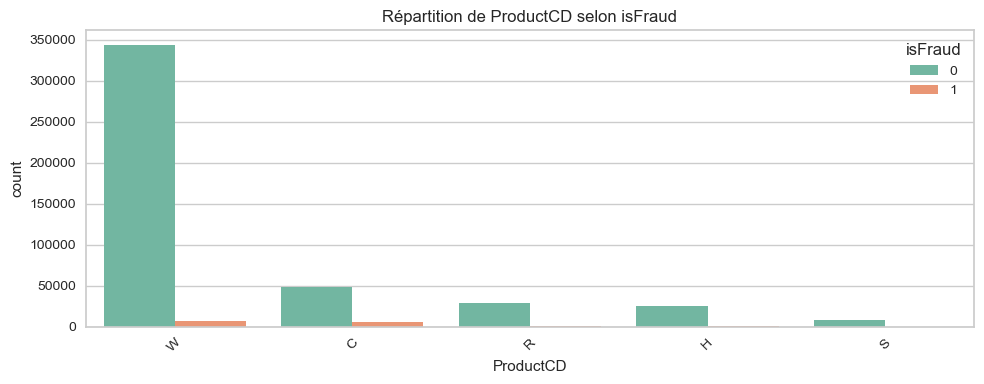


=== Analyse de la variable : card4 ===
Valeurs uniques et fréquences :
card4
visa                307711
mastercard          151547
american express      6658
discover              5273
None                  1243
Name: count, dtype: int64

Taux de fraude par modalité :
card4
discover            0.077944
visa                0.034734
mastercard          0.034293
american express    0.030339
Name: isFraud, dtype: float64


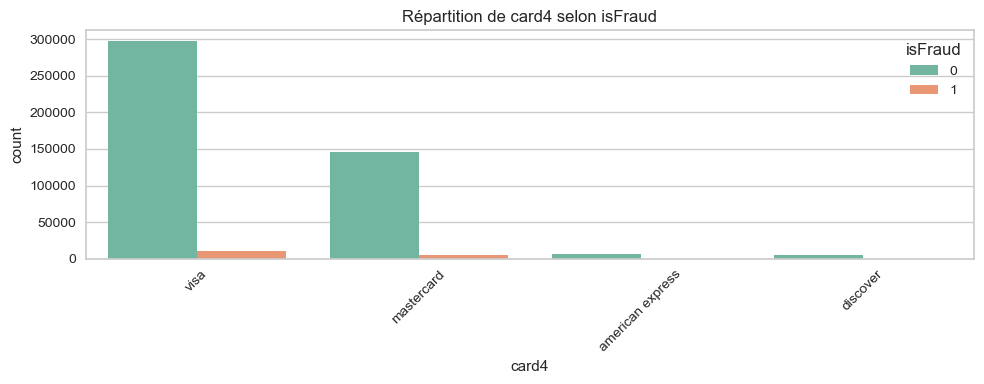


=== Analyse de la variable : card6 ===
Valeurs uniques et fréquences :
card6
debit              351871
credit             119283
None                 1240
debit or credit        25
charge card            13
Name: count, dtype: int64

Taux de fraude par modalité :
card6
credit             0.066942
debit              0.024196
charge card        0.000000
debit or credit    0.000000
Name: isFraud, dtype: float64


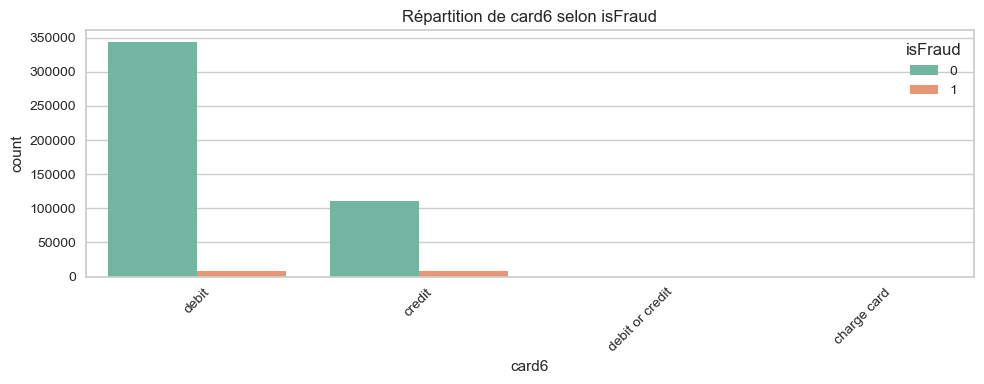


=== Analyse de la variable : P_emaildomain ===
Valeurs uniques et fréquences :
P_emaildomain
gmail.com        182612
yahoo.com         80629
None              75591
hotmail.com       36283
anonymous.com     29774
aol.com           22572
comcast.net        6215
icloud.com         5015
outlook.com        4141
msn.com            3283
Name: count, dtype: int64

Taux de fraude par modalité :
P_emaildomain
protonmail.com    0.410714
mail.com          0.180435
outlook.es        0.132353
aim.com           0.115385
outlook.com       0.091765
hotmail.es        0.059091
hotmail.com       0.052862
live.com.mx       0.050903
gmail.com         0.043590
embarqmail.com    0.033981
Name: isFraud, dtype: float64


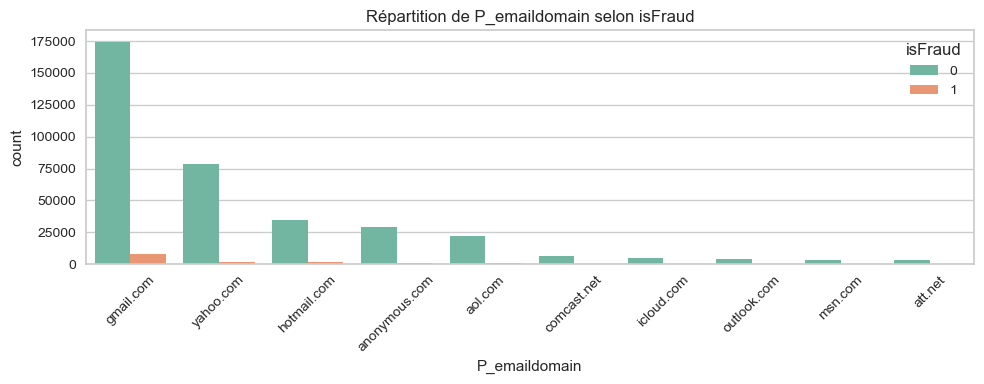


=== Analyse de la variable : R_emaildomain ===
Valeurs uniques et fréquences :
R_emaildomain
None             362236
gmail.com         45780
hotmail.com       22126
anonymous.com     16500
yahoo.com          9484
aol.com            2965
outlook.com        2053
comcast.net        1442
yahoo.com.mx       1210
icloud.com         1106
Name: count, dtype: int64

Taux de fraude par modalité :
R_emaildomain
protonmail.com    0.937500
mail.com          0.377551
outlook.com       0.155869
netzero.net       0.142857
outlook.es        0.133531
icloud.com        0.127486
gmail.com         0.118917
earthlink.net     0.103448
hotmail.com       0.077375
hotmail.es        0.061321
Name: isFraud, dtype: float64


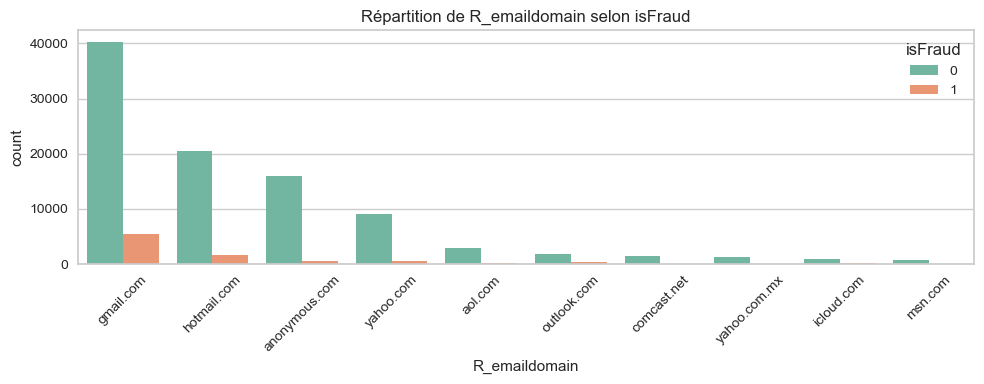


=== Analyse de la variable : M1 ===
Valeurs uniques et fréquences :
M1
T       255291
None    217120
F           21
Name: count, dtype: int64

Taux de fraude par modalité :
M1
T    0.020114
F    0.000000
Name: isFraud, dtype: float64


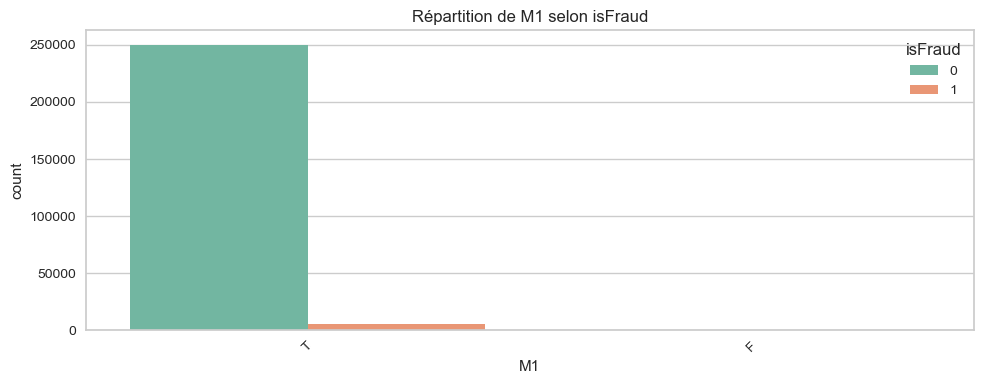


=== Analyse de la variable : M2 ===
Valeurs uniques et fréquences :
M2
T       228205
None    217120
F        27107
Name: count, dtype: int64

Taux de fraude par modalité :
M2
F    0.035600
T    0.018273
Name: isFraud, dtype: float64


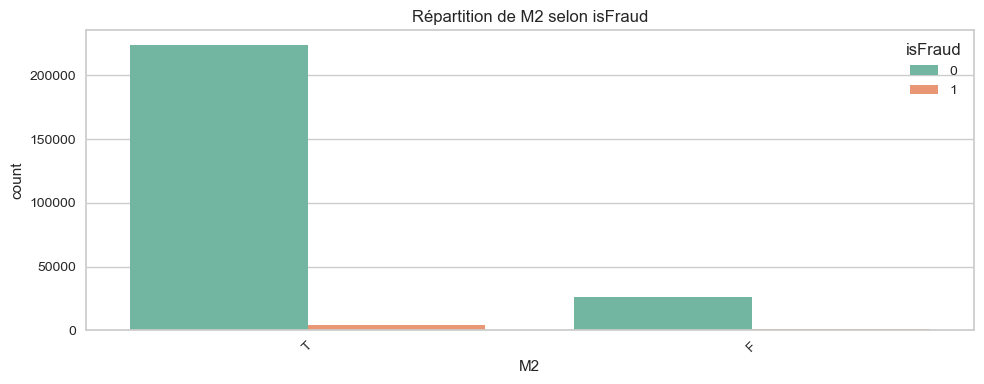


=== Analyse de la variable : M3 ===
Valeurs uniques et fréquences :
M3
None    217120
T       201291
F        54021
Name: count, dtype: int64

Taux de fraude par modalité :
M3
F    0.030692
T    0.017273
Name: isFraud, dtype: float64


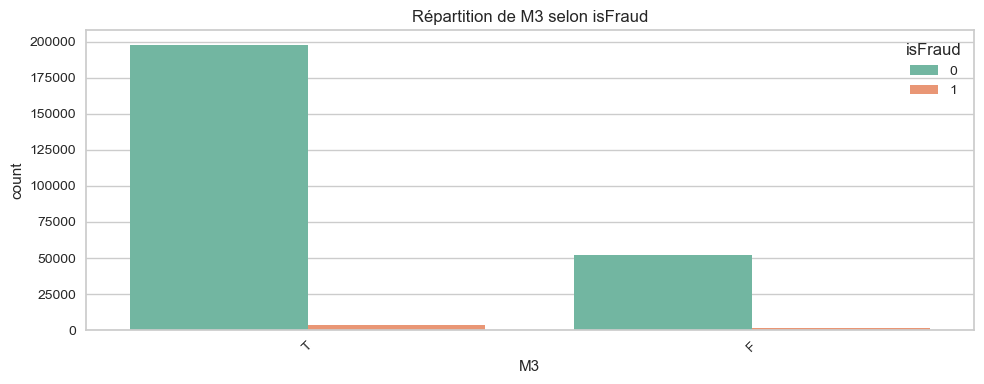


=== Analyse de la variable : M4 ===
Valeurs uniques et fréquences :
M4
None    224903
M0      157124
M2       48046
M1       42359
Name: count, dtype: int64

Taux de fraude par modalité :
M4
M2    0.113162
M0    0.036614
M1    0.027739
Name: isFraud, dtype: float64


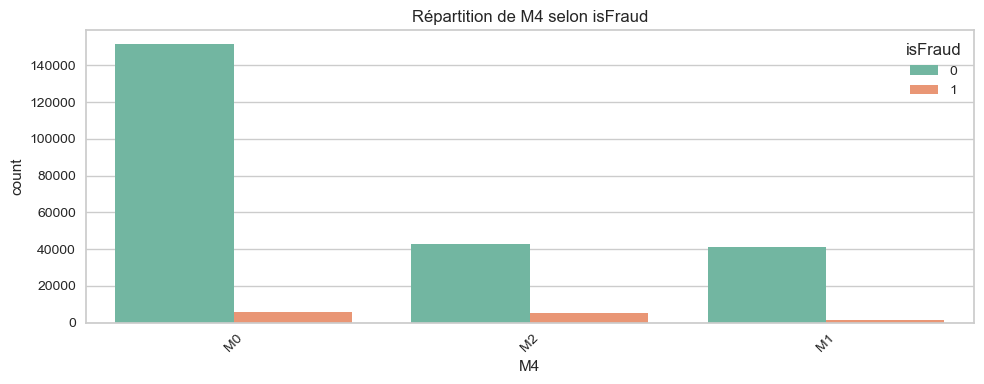


=== Analyse de la variable : M5 ===
Valeurs uniques et fréquences :
M5
None    280337
F       105945
T        86150
Name: count, dtype: int64

Taux de fraude par modalité :
M5
T    0.037725
F    0.026589
Name: isFraud, dtype: float64


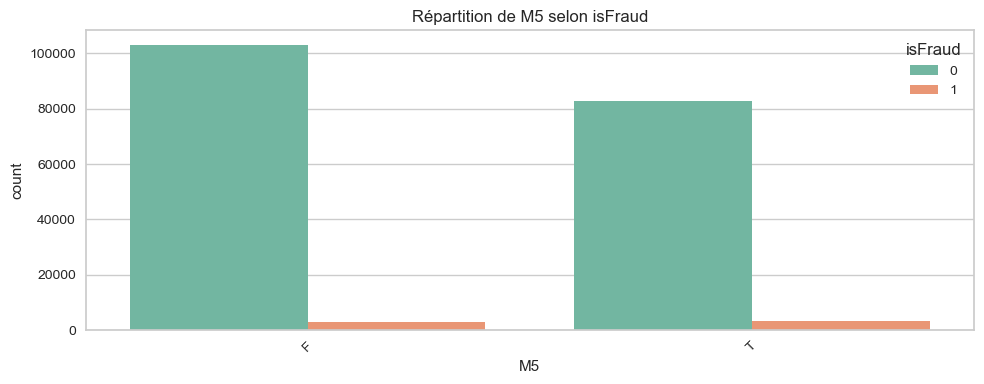


=== Analyse de la variable : M6 ===
Valeurs uniques et fréquences :
M6
F       182245
T       154395
None    135792
Name: count, dtype: int64

Taux de fraude par modalité :
M6
F    0.023869
T    0.016898
Name: isFraud, dtype: float64


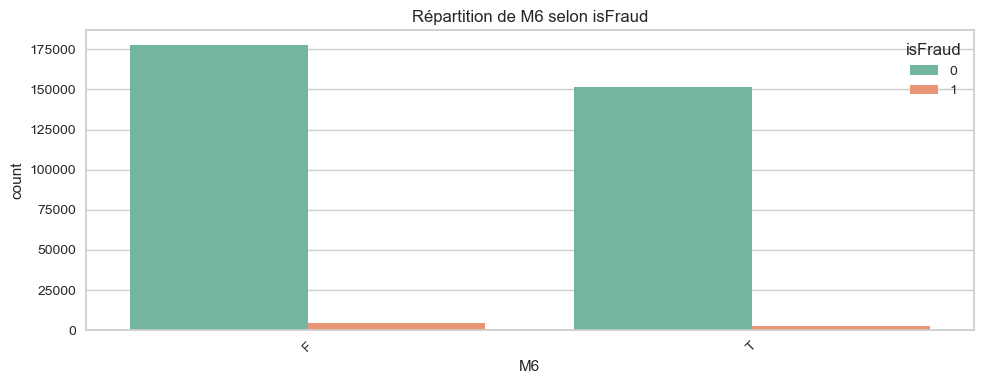


=== Analyse de la variable : M7 ===
Valeurs uniques et fréquences :
M7
None    277327
F       168751
T        26354
Name: count, dtype: int64

Taux de fraude par modalité :
M7
T    0.021970
F    0.019621
Name: isFraud, dtype: float64


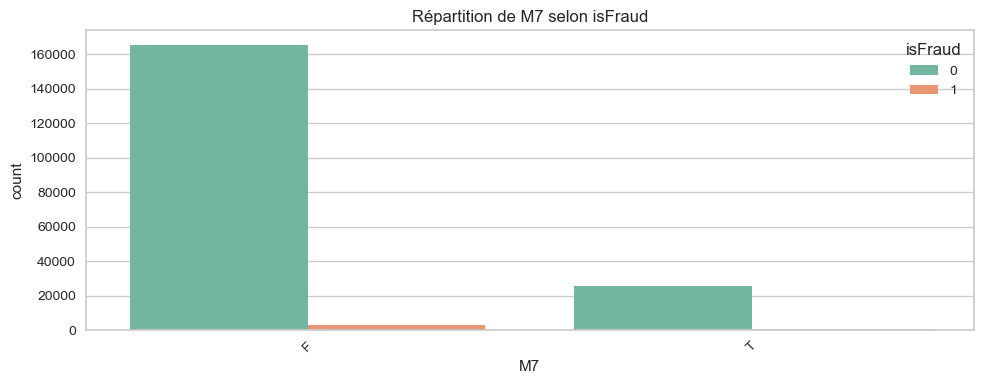


=== Analyse de la variable : M8 ===
Valeurs uniques et fréquences :
M8
None    277317
F       123937
T        71178
Name: count, dtype: int64

Taux de fraude par modalité :
M8
F    0.022116
T    0.016143
Name: isFraud, dtype: float64


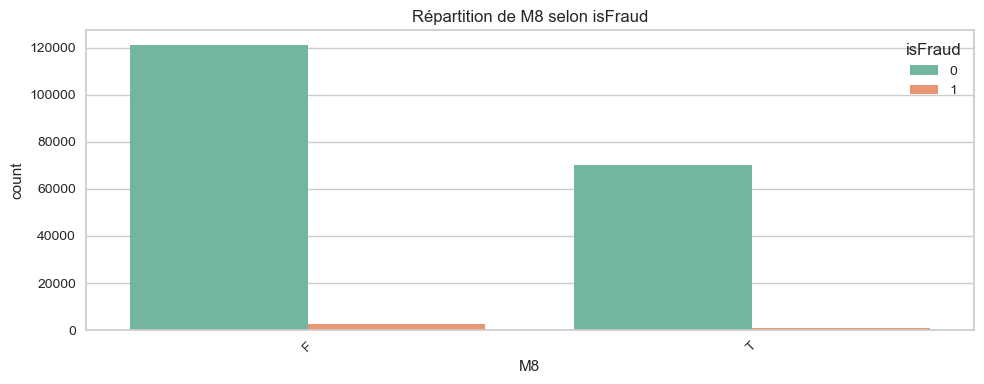


=== Analyse de la variable : M9 ===
Valeurs uniques et fréquences :
M9
None    277317
T       164245
F        30870
Name: count, dtype: int64

Taux de fraude par modalité :
M9
F    0.030094
T    0.018028
Name: isFraud, dtype: float64


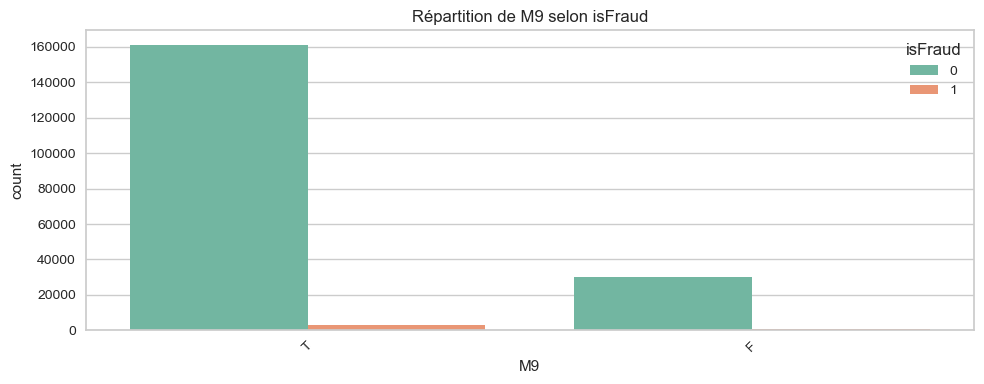


=== Analyse de la variable : id_12 ===
Valeurs uniques et fréquences :
id_12
NaN         356774
NotFound     98626
Found        17032
Name: count, dtype: int64

Taux de fraude par modalité :
id_12
NotFound    0.081368
Found       0.059124
Name: isFraud, dtype: float64


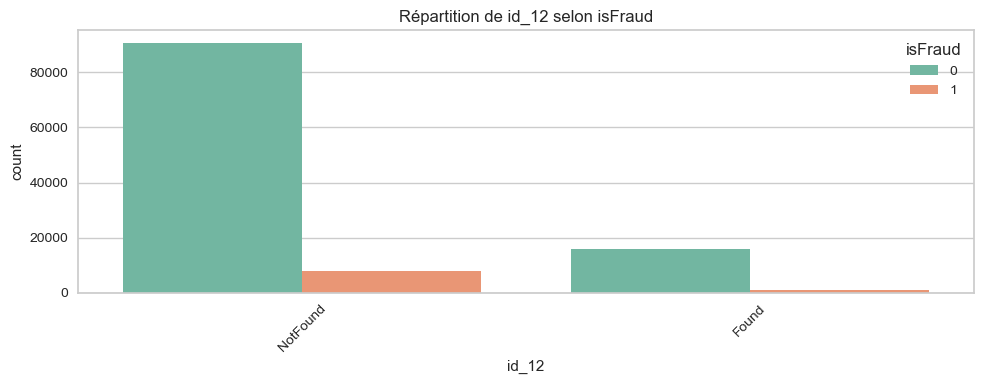


=== Analyse de la variable : id_15 ===
Valeurs uniques et fréquences :
id_15
NaN        356774
Found       54304
New         49360
Unknown      9421
None         2573
Name: count, dtype: int64

Taux de fraude par modalité :
id_15
Found      0.104210
Unknown    0.089163
New        0.049696
Name: isFraud, dtype: float64


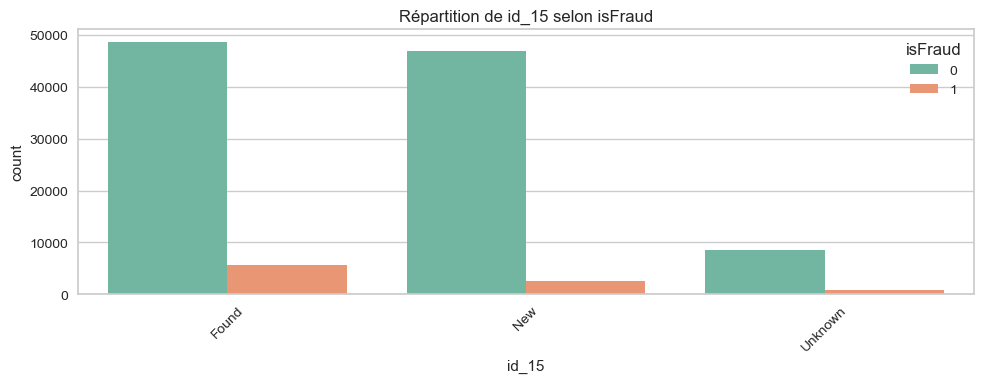


=== Analyse de la variable : id_16 ===
Valeurs uniques et fréquences :
id_16
NaN         356774
Found        53192
NotFound     50472
None         11994
Name: count, dtype: int64

Taux de fraude par modalité :
id_16
Found       0.106294
NotFound    0.048700
Name: isFraud, dtype: float64


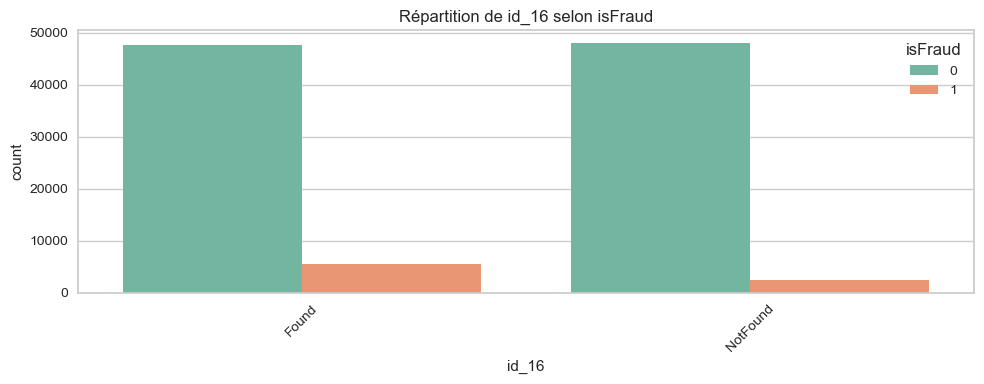


=== Analyse de la variable : id_28 ===
Valeurs uniques et fréquences :
id_28
NaN      356774
Found     61172
New       51907
None       2579
Name: count, dtype: int64

Taux de fraude par modalité :
id_28
Found    0.102073
New      0.052112
Name: isFraud, dtype: float64


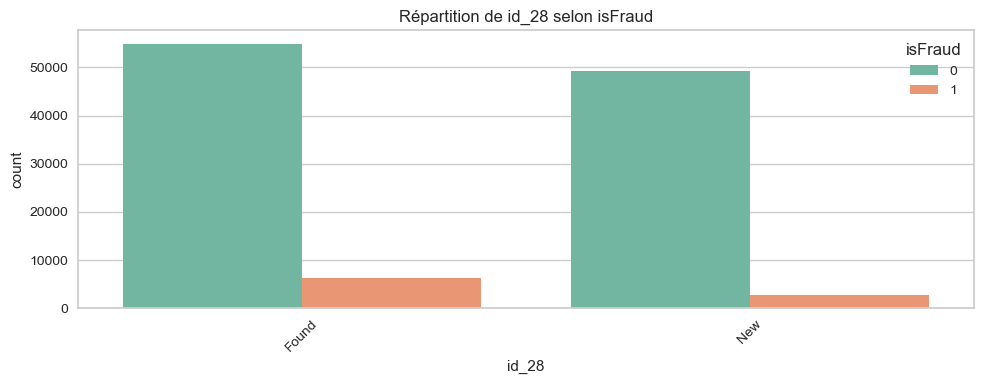


=== Analyse de la variable : id_29 ===
Valeurs uniques et fréquences :
id_29
NaN         356774
Found        60129
NotFound     52950
None          2579
Name: count, dtype: int64

Taux de fraude par modalité :
id_29
Found       0.10376
NotFound    0.05118
Name: isFraud, dtype: float64


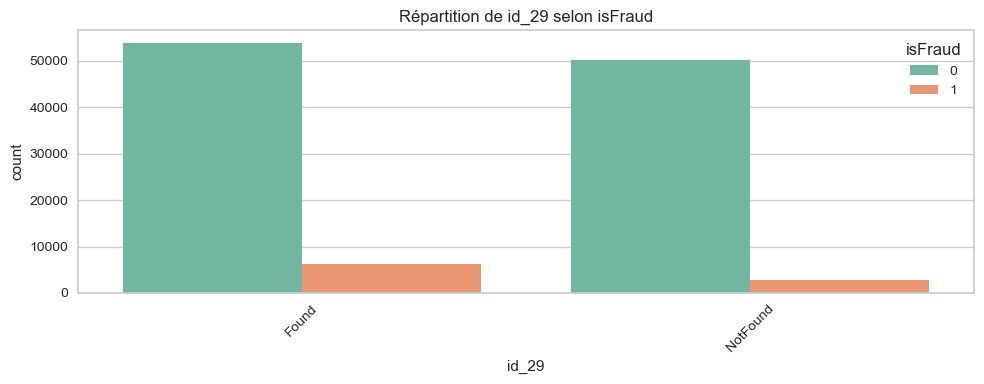


=== Analyse de la variable : id_30 ===
Valeurs uniques et fréquences :
id_30
NaN                 356774
None                 53475
Windows 10           16898
Windows 7            10515
iOS 11.2.1            2986
iOS 11.1.2            2971
Android 7.0           2302
Mac OS X 10_12_6      2018
Mac OS X 10_11_6      1899
iOS 11.3.0            1629
Name: count, dtype: int64

Taux de fraude par modalité :
id_30
other            0.600000
Android 5.1.1    0.265455
Android 4.4.2    0.255319
iOS 11.4.0       0.200000
iOS 11.0.1       0.190000
iOS 11.1.0       0.158371
Android 7.1.2    0.148148
iOS 11.2.5       0.120812
iOS 11.2.2       0.117007
Windows 8        0.115646
Name: isFraud, dtype: float64


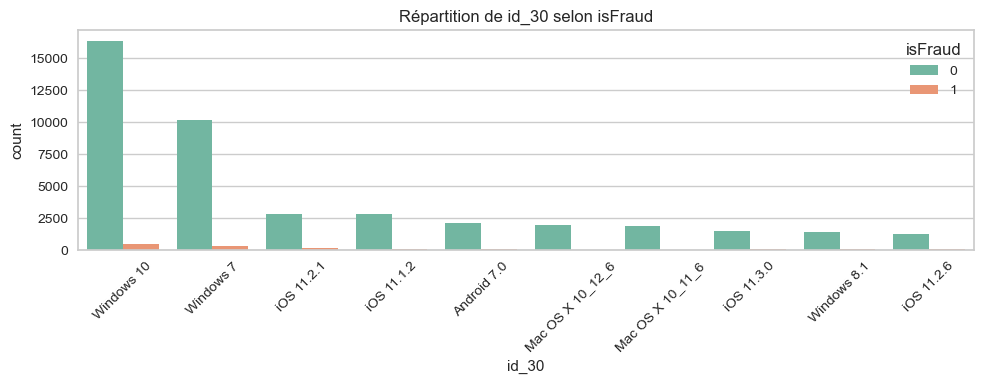


=== Analyse de la variable : id_31 ===
Valeurs uniques et fréquences :
id_31
NaN                        356774
chrome 63.0                 17613
mobile safari 11.0          10765
mobile safari generic        9244
ie 11.0 for desktop          7262
safari generic               6549
chrome 62.0                  5736
chrome 65.0                  5489
chrome 64.0                  5360
chrome 63.0 for android      4664
Name: count, dtype: int64

Taux de fraude par modalité :
id_31
icedragon                  1.000000
Lanix/Ilium                1.000000
Mozilla/Firefox            1.000000
comodo                     0.600000
chrome 49.0 for android    0.525000
opera                      0.444444
opera generic              0.423729
chrome 52.0 for android    0.393701
opera 51.0                 0.333333
opera 49.0                 0.312500
Name: isFraud, dtype: float64


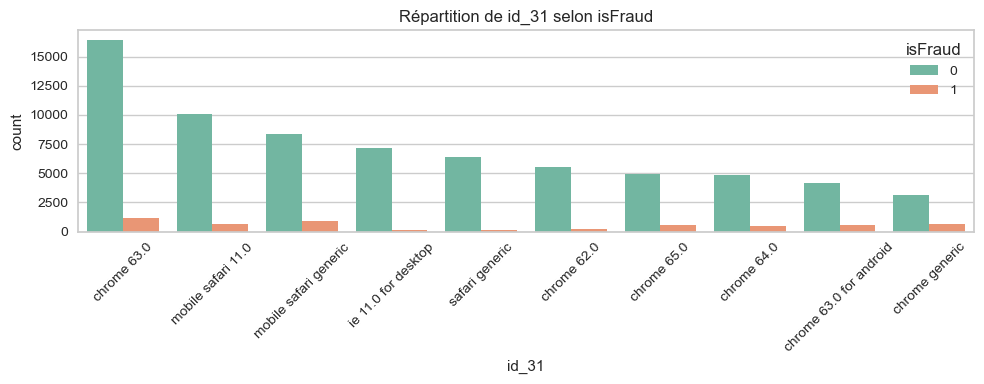


=== Analyse de la variable : id_33 ===
Valeurs uniques et fréquences :
id_33
NaN          356774
None          56868
1920x1080     13526
1366x768       6870
1334x750       5181
2208x1242      3967
1440x900       3528
1600x900       2785
2048x1536      2771
1280x800       1733
Name: count, dtype: int64

Taux de fraude par modalité :
id_33
1916x901     1.000000
1024x552     1.000000
1920x975     1.000000
2076x1080    1.000000
640x360      1.000000
1364x768     0.812500
1768x992     0.666667
1024x600     0.656250
4500x3000    0.600000
0x0          0.500000
Name: isFraud, dtype: float64


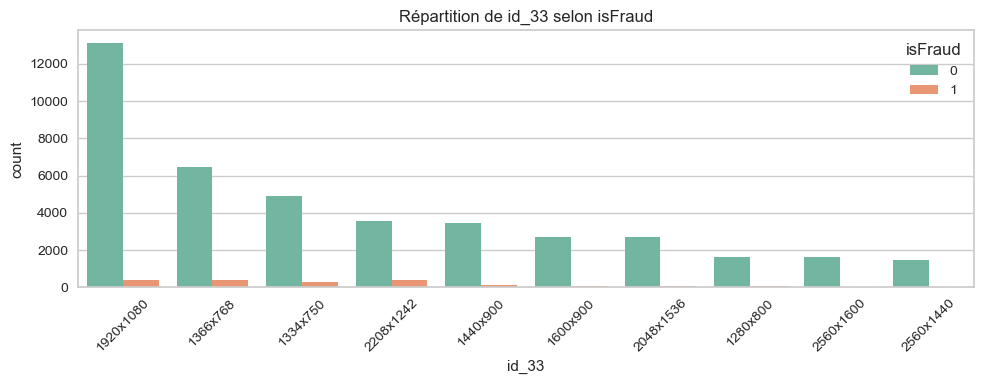


=== Analyse de la variable : id_34 ===
Valeurs uniques et fréquences :
id_34
NaN                356774
None                53288
match_status:2      48035
match_status:1      13988
match_status:0        345
match_status:-1         2
Name: count, dtype: int64

Taux de fraude par modalité :
id_34
match_status:1     0.063126
match_status:0     0.052174
match_status:2     0.038743
match_status:-1    0.000000
Name: isFraud, dtype: float64


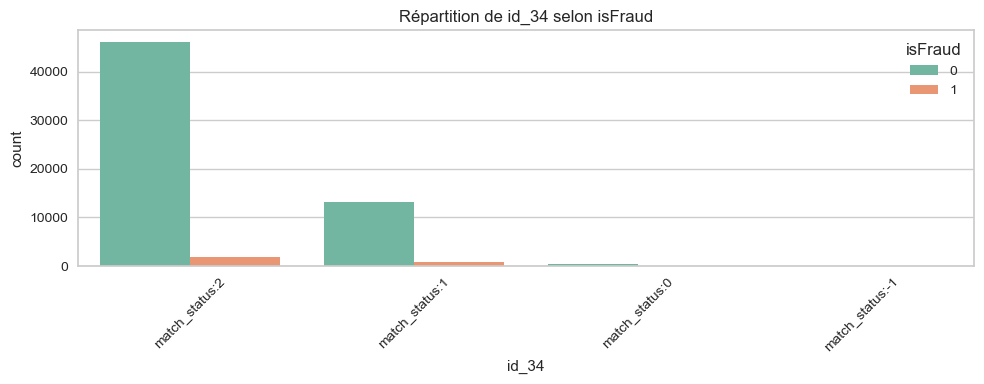


=== Analyse de la variable : id_35 ===
Valeurs uniques et fréquences :
id_35
NaN     356774
T        62382
F        50703
None      2573
Name: count, dtype: int64

Taux de fraude par modalité :
id_35
F    0.122202
T    0.044179
Name: isFraud, dtype: float64


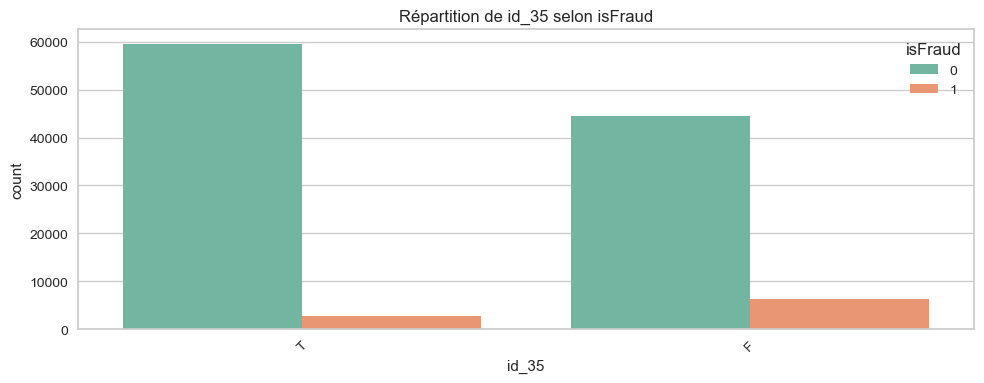


=== Analyse de la variable : id_36 ===
Valeurs uniques et fréquences :
id_36
NaN     356774
F       107554
T         5531
None      2573
Name: count, dtype: int64

Taux de fraude par modalité :
id_36
F    0.081485
T    0.033990
Name: isFraud, dtype: float64


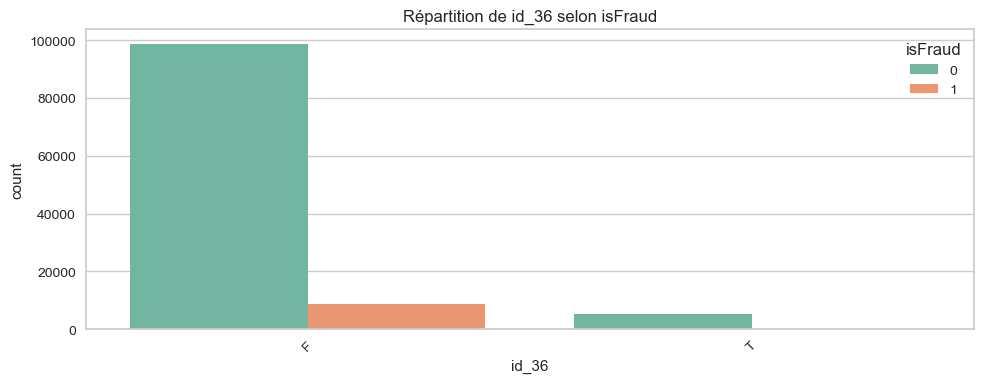


=== Analyse de la variable : id_37 ===
Valeurs uniques et fréquences :
id_37
NaN     356774
T        88429
F        24656
None      2573
Name: count, dtype: int64

Taux de fraude par modalité :
id_37
T    0.083072
F    0.065136
Name: isFraud, dtype: float64


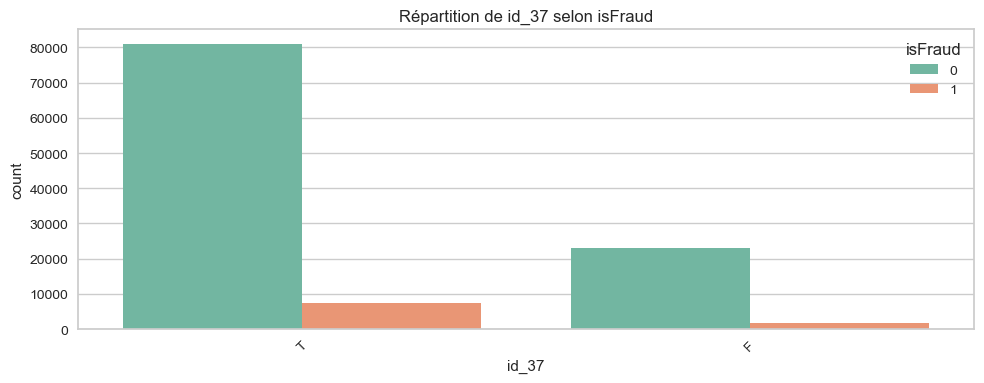


=== Analyse de la variable : id_38 ===
Valeurs uniques et fréquences :
id_38
NaN     356774
F        59290
T        53795
None      2573
Name: count, dtype: int64

Taux de fraude par modalité :
id_38
F    0.097723
T    0.058704
Name: isFraud, dtype: float64


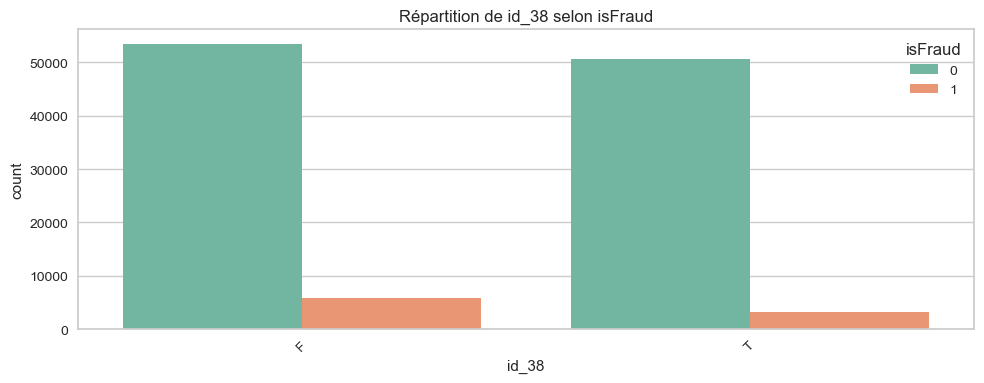


=== Analyse de la variable : DeviceType ===
Valeurs uniques et fréquences :
DeviceType
NaN        356774
desktop     68173
mobile      44762
None         2723
Name: count, dtype: int64

Taux de fraude par modalité :
DeviceType
mobile     0.100643
desktop    0.065099
Name: isFraud, dtype: float64


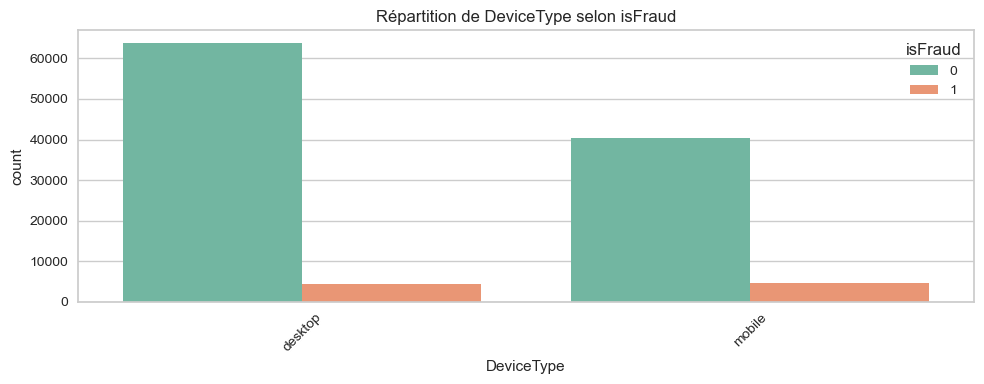


=== Analyse de la variable : DeviceInfo ===
Valeurs uniques et fréquences :
DeviceInfo
NaN                      356774
Windows                   38127
None                      20451
iOS Device                15942
MacOS                     10074
Trident/7.0                6004
rv:11.0                    1506
rv:57.0                     800
SM-J700M Build/MMB29K       436
SM-G610M Build/MMB29K       378
Name: count, dtype: int64

Taux de fraude par modalité :
DeviceInfo
iPhone                  1.0
Z965 Build/NMF26V       1.0
SM-A710M                1.0
Nexus 6 Build/MOB30M    1.0
NX785QC8G               1.0
NOKIA                   1.0
XT1609                  1.0
N9560 Build/NMF26F      1.0
A574BL Build/NMF26F     1.0
Mi                      1.0
Name: isFraud, dtype: float64


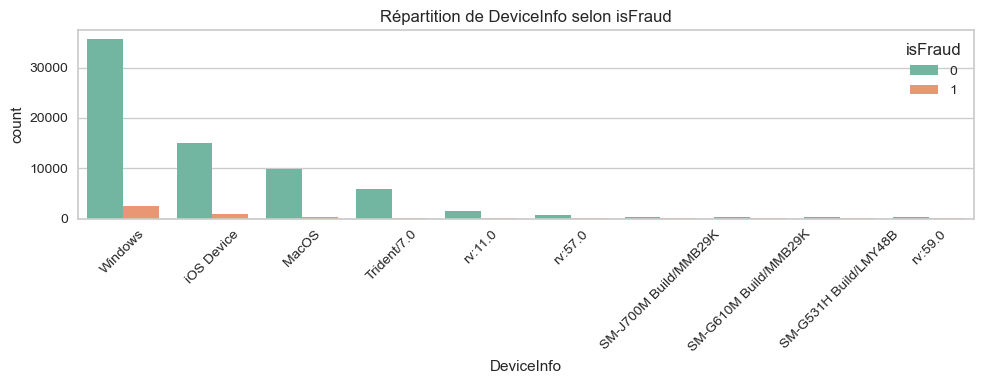

In [39]:
 # Étape 1 : pourcentage de valeurs manquantes
missing_info = train1[categorical_vars].isnull().mean().sort_values(ascending=False)
print("Taux de valeurs manquantes :")
print(missing_info)

# Étape 2 : boucle d'analyse pour chaque variable
for col in categorical_vars:
    print(f"\n=== Analyse de la variable : {col} ===")

    # Top modalités
    print("Valeurs uniques et fréquences :")
    print(train1[col].value_counts(dropna=False).head(10))

    # Taux de fraude par modalité (top 10 seulement pour éviter surcharge visuelle)
    print("\nTaux de fraude par modalité :")
    fraud_rate = train1.groupby(col)['isFraud'].mean().sort_values(ascending=False)
    print(fraud_rate.head(10))
# Graphiques
    plt.figure(figsize=(10, 4))
    sns.countplot(data=train1, x=col, order=train1[col].value_counts().iloc[:10].index,
                  hue='isFraud', palette='Set2')
    plt.title(f"Répartition de {col} selon isFraud")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Nous allons par la suite regarder de plus près ces variables par groupe.

### Variables Devicetype et DeviceInfo

In [40]:
desc_col(expr='Device', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

DeviceType: object, 2 valeurs uniques, 76.09% de valeurs manquantes
Valeurs uniques : ['desktop' 'mobile' nan None]

DeviceInfo: object, 1686 valeurs uniques, 79.85% de valeurs manquantes
Valeurs uniques : ['0PJA2' '0PM92' '1016S' ... 'xs-Z47b7VqTMxs' nan None]



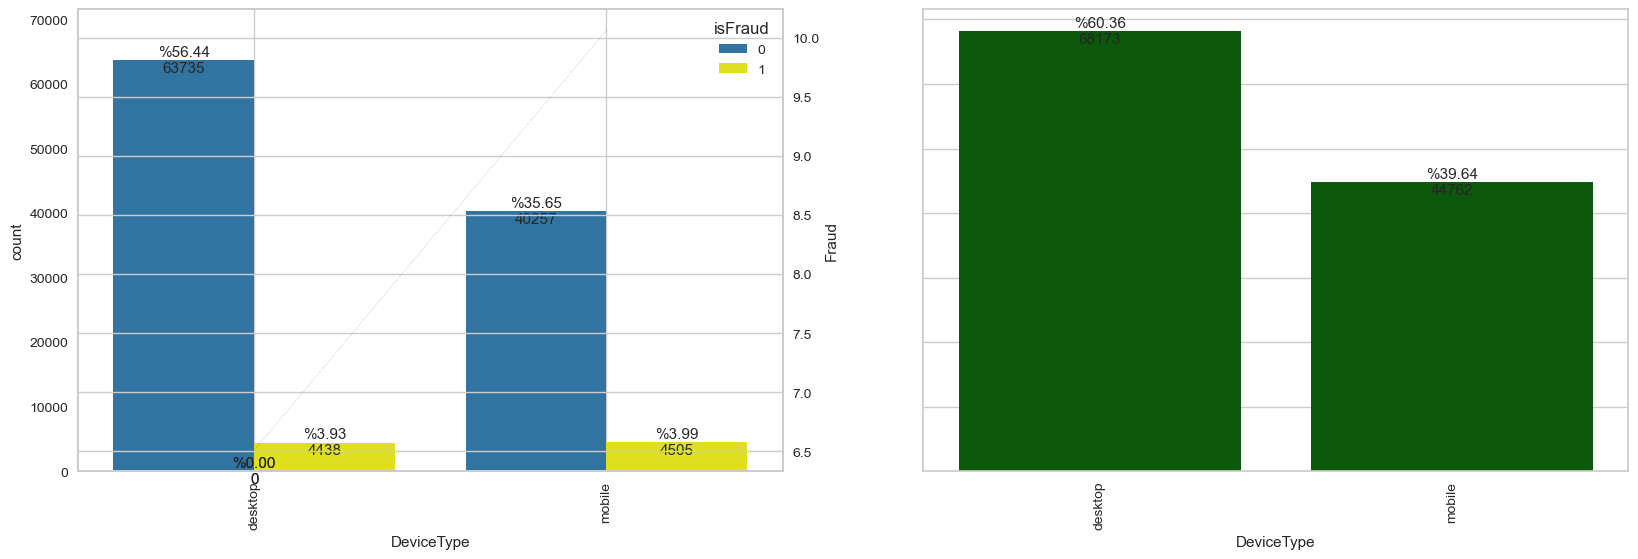

In [41]:
plot_col(col='DeviceType', df=train1)

In [42]:
# Tester si les NA de DeviceInfo et DeviceType creent une différence significative dans le taux de fraude
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Fonction de test du taux de fraude selon présence ou non de valeurs manquantes
def test_na_fraud_rate(df, col):
    group_na = df[df[col].isnull()]['isFraud']
    group_not_na = df[df[col].notnull()]['isFraud']
    count = np.array([group_na.sum(), group_not_na.sum()])
    nobs = np.array([group_na.count(), group_not_na.count()])
    stat, pval = proportions_ztest(count, nobs)
    return pval

# Application du test sur deux colonnes
test_deviceinfo = test_na_fraud_rate(train1, 'DeviceInfo')
test_devicetype = test_na_fraud_rate(train1, 'DeviceType')
print(f"P-value pour DeviceInfo : {test_deviceinfo:.4f}")
print(f"P-value pour DeviceType : {test_devicetype:.4f}")

P-value pour DeviceInfo : 0.0000
P-value pour DeviceType : 0.0000


In [43]:
# Définir les appareils principaux à conserver
top_devices = ['Windows', 'iOS Device', 'MacOS', 'Trident/7.0']

# Calculer les deux colonnes séparément (sans modifier train1 pour l’instant)
deviceinfo_processed = train1['DeviceInfo'].where(train1['DeviceInfo'].isin(top_devices), 'Other_Device').fillna('Unknown')
devicetype_imputed = train1['DeviceType'].fillna('Unknown')

# Utiliser assign pour ajouter les colonnes en une seule opération (évite la fragmentation)
train1 = train1.assign(
    DeviceInfo_processed=deviceinfo_processed,
    DeviceType_imputed=devicetype_imputed
)


Le test etant significatif, nous gardons les valeurs manquantes et nous imputons les colonnes créées à partir de DeviceType et DeviceInfo par Unknown.

### Variables commençant par 'id'

In [44]:
id_cols = [col for col in train1.columns if col.startswith('id_')]
print(f" {len(id_cols)} colonnes trouvées qui commencent par 'id_':\n")
print(id_cols)

 28 colonnes trouvées qui commencent par 'id_':

['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


Visualisation des valeurs manquantes (colonnes 'id_'):


<Axes: >

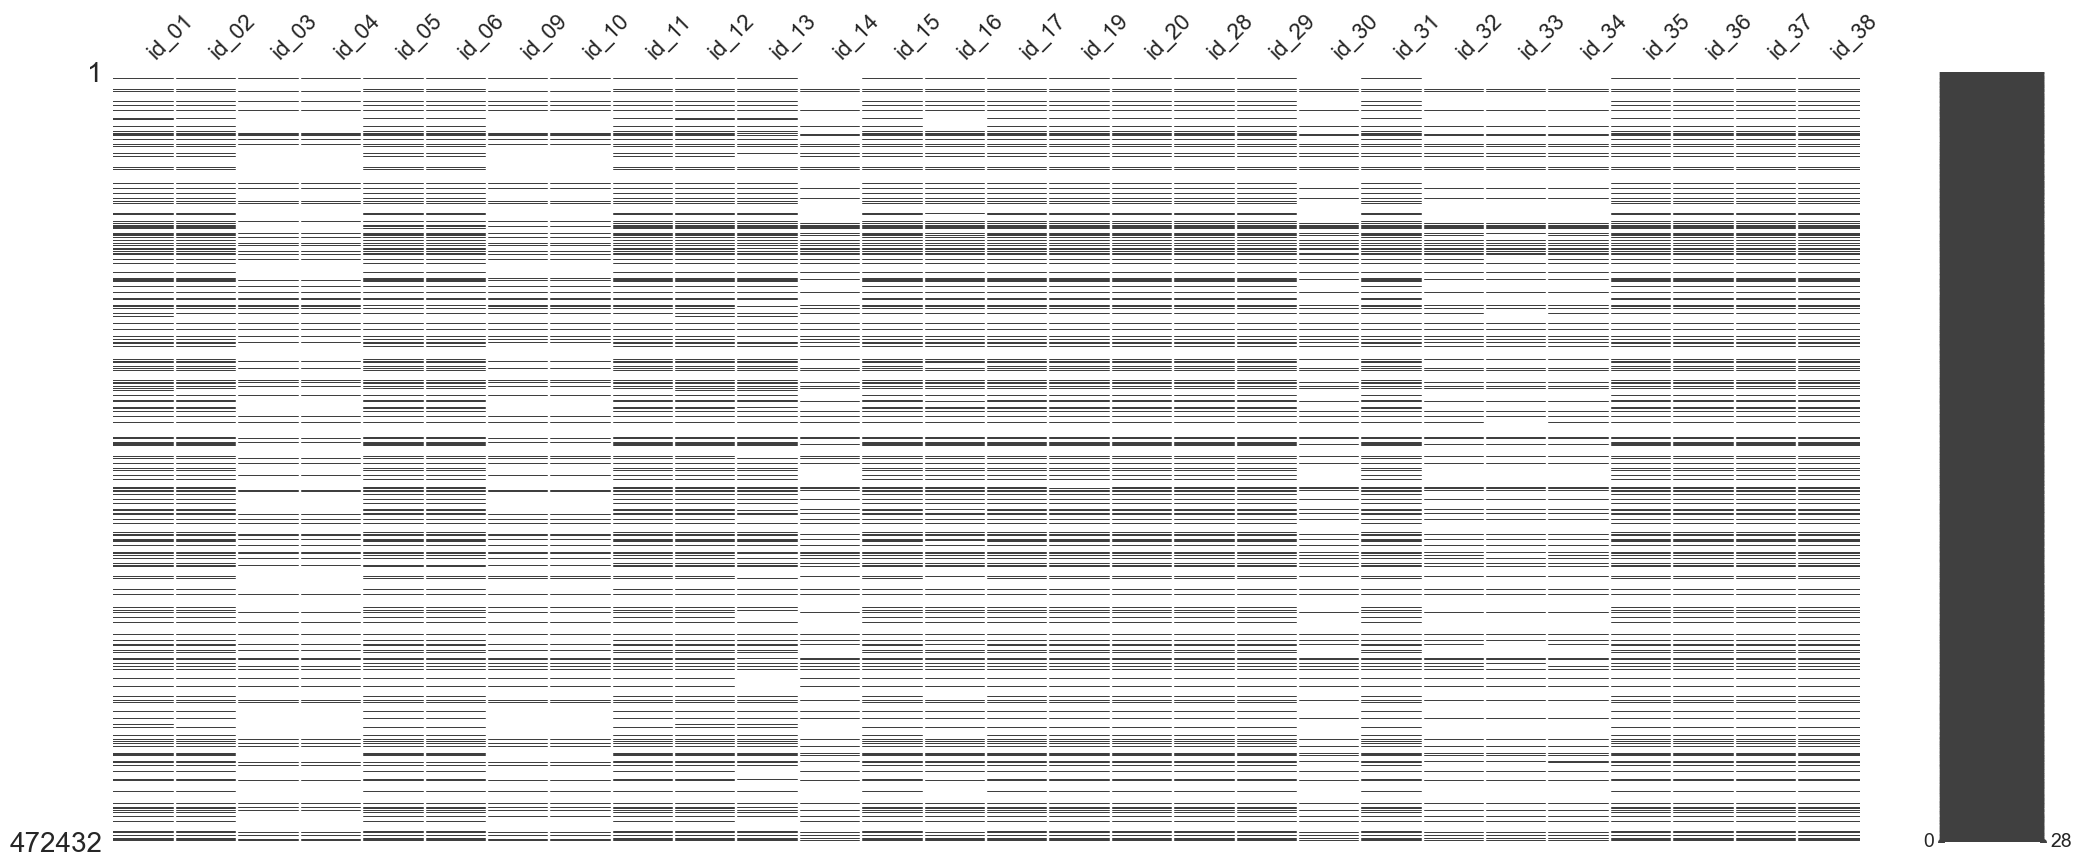

In [45]:
import missingno as msno

print("Visualisation des valeurs manquantes (colonnes 'id_'):")
msno.matrix(train1[id_cols])

On peut voir que certaines variables commençant par id présentent les même distributions de valeurs manquantes. Ces variables sont des identifiants d'identification non explicitement décrites. Nous gardons donc ces valeurs manquantes.

In [46]:
# Imputation des NA par 'undefined' sur les variables id_
id_cat_vars = [col for col in train.columns if col.startswith("id") and train[col].dtype in ['object', 'category']]
for col in id_cat_vars:
    train[col] = train[col].fillna('undefined')

On commence à détecter les liaisons entre ces variables par le test du khi2 et le V de CRAMER

In [47]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Fonction pour calculer le V de Cramer
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom == 0:
        return 0.0
    return np.sqrt(phi2corr / denom)

# Fonction pour calculer p-value du chi2 et cramers_v
def chi2_and_cramers_v(var1, var2, df):
    contingency_table = pd.crosstab(df[var1], df[var2])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    cramers = cramers_v(df[var1], df[var2])
    return p, cramers


In [48]:

# 1. Sélection des variables ID catégorielles (dtype 'object' ou 'category')
id_cat_vars = [col for col in train1.columns if col.startswith("id") and train1[col].dtype in ['object', 'category']]

print("Variables id catégorielles :", id_cat_vars)

# 2. Calcul des tests et mesures de liaison pour toutes les paires
results = []
for i, var1 in enumerate(id_cat_vars):
    for var2 in id_cat_vars[i+1:]:
        try:
            p_val, cramers_v_val = chi2_and_cramers_v(var1, var2, train1)
            results.append({'var1': var1, 'var2': var2, 'p_val': p_val, 'cramers_v': cramers_v_val})
        except Exception as e:
            print(f"Erreur sur paire ({var1}, {var2}) : {e}")



Variables id catégorielles : ['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [49]:
# 3. Création du DataFrame résultat
df_results = pd.DataFrame(results)

# 4. Filtrage pour fortes dépendances (par exemple p < 0.05 et cramers_v > 0.7)
strongly_correlated = df_results[(df_results['p_val'] < 0.05) & (df_results['cramers_v'] > 0.7)]

print("Paires fortement corrélées :")
print(strongly_correlated)


Paires fortement corrélées :
     var1   var2  p_val  cramers_v
12  id_15  id_16    0.0   0.978725
13  id_15  id_28    0.0   0.885268
14  id_15  id_29    0.0   0.864880
23  id_16  id_28    0.0   0.875906
24  id_16  id_29    0.0   0.891773
33  id_28  id_29    0.0   0.981607
61  id_31  id_37    0.0   0.742150


### R_emaildomain et P_email domain

Nous décomposons l’adresse e-mail en deux parties pour les deux variables :

R_emaildomain_1 : le fournisseur principal de l’e-mail (avant le premier point).

R_emaildomain_2 : la suite du domaine (après le premier point, ex. com, co.uk, etc.).

Cela permet d’analyser séparément les différents niveaux du domaine d’e-mail, ce qui peut aider à mieux comprendre certains comportements liés à la fraude.

In [50]:
desc_col(expr='emaildomain', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

P_emaildomain: object, 59 valeurs uniques, 16.0% de valeurs manquantes
Valeurs uniques : ['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk' 'yahoo.com' 'yahoo.com.mx'
 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com' None]

R_emaildomain: objec

In [51]:
# Pour R_emaildomain
train1['R_emaildomain_1'] = train1['R_emaildomain'].fillna('').apply(
    lambda x: x.split('.')[0] if x else np.nan
).replace({'': np.nan})

train1['R_emaildomain_2'] = train1['R_emaildomain'].fillna('').apply(
    lambda x: '.'.join(x.split('.')[1:]).strip('.') if '.' in x else np.nan
).replace({'': np.nan})

# Pour P_emaildomain
train1['P_emaildomain_1'] = train1['P_emaildomain'].fillna('').apply(
    lambda x: x.split('.')[0] if x else np.nan
).replace({'': np.nan})

train1['P_emaildomain_2'] = train1['P_emaildomain'].fillna('').apply(
    lambda x: '.'.join(x.split('.')[1:]).strip('.') if '.' in x else np.nan
).replace({'': np.nan})


In [52]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Exemple : association entre domaines suffixes
v_cramer = cramers_v(train1['R_emaildomain_2'], train1['P_emaildomain_2'])
print("V de Cramér :", round(v_cramer, 3))


V de Cramér : 0.89


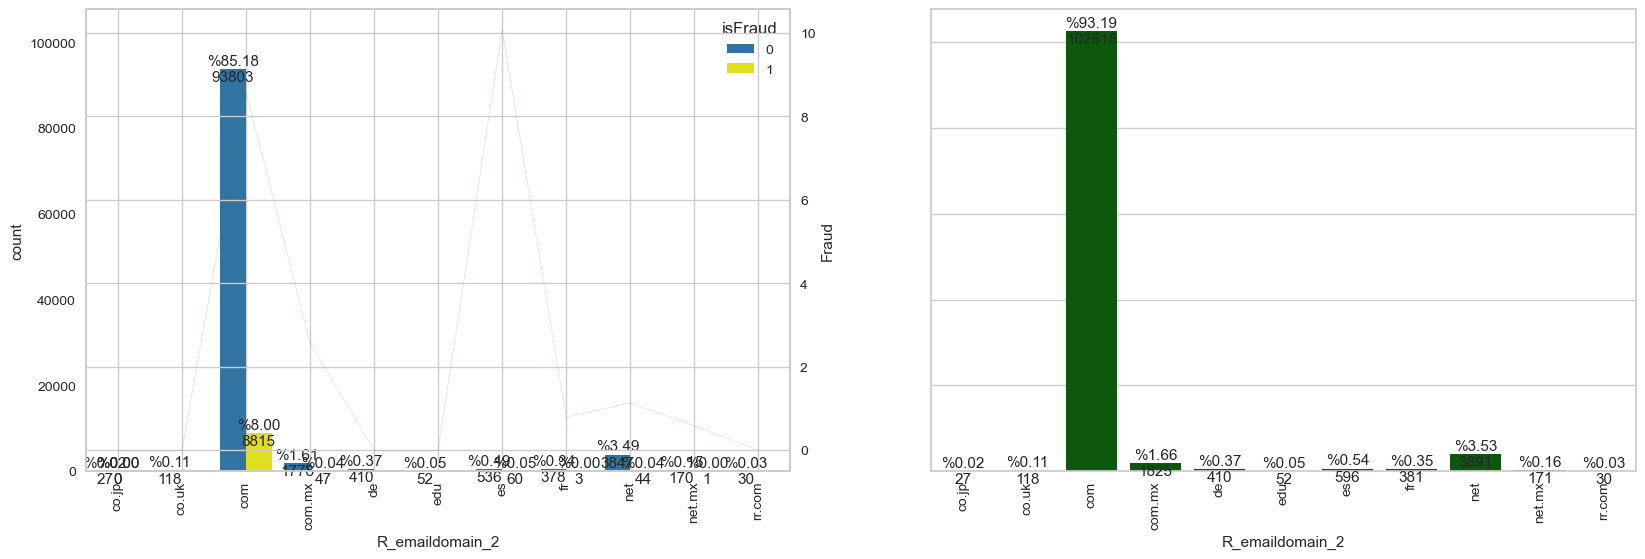

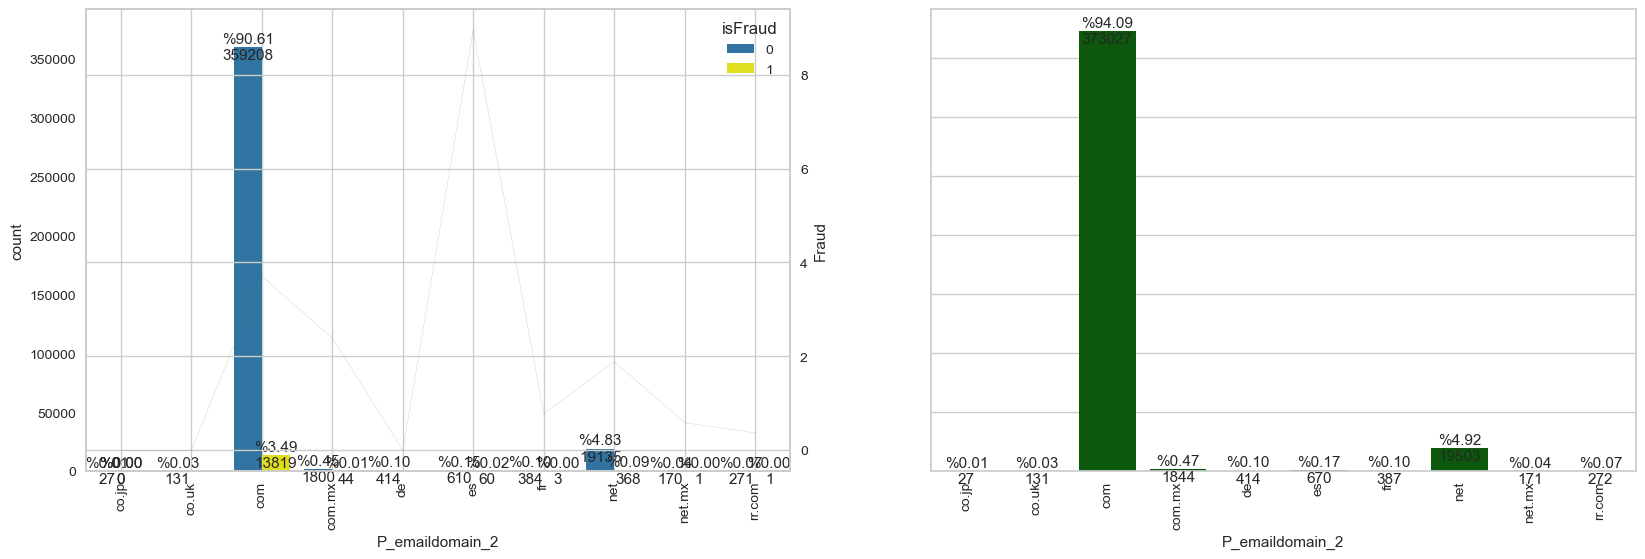

In [53]:
for col in ['R_emaildomain_2', 'P_emaildomain_2']:
  plot_col(col, df=train1)

In [54]:
train1['R_emaildomain_1'] = train1['R_emaildomain_1'].fillna('undefined')
train1['R_emaildomain_2'] = train1['R_emaildomain_2'].fillna('undefined')

In [55]:
train1['P_emaildomain_1'] = train1['P_emaildomain_1'].fillna('undefined')
train1['P_emaildomain_2'] = train1['P_emaildomain_2'].fillna('undefined')

### Variables commençant par M

In [56]:
desc_col(expr='M', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

M1: object, 2 valeurs uniques, 45.96% de valeurs manquantes
Valeurs uniques : ['F' 'T' None]

M2: object, 2 valeurs uniques, 45.96% de valeurs manquantes
Valeurs uniques : ['F' 'T' None]

M3: object, 2 valeurs uniques, 45.96% de valeurs manquantes
Valeurs uniques : ['F' 'T' None]

M4: object, 3 valeurs uniques, 47.61% de valeurs manquantes
Valeurs uniques : ['M0' 'M1' 'M2' None]

M5: object, 2 valeurs uniques, 59.34% de valeurs manquantes
Valeurs uniques : ['F' 'T' None]

M6: object, 2 valeurs uniques, 28.74% de valeurs manquantes
Valeurs uniques : ['F' 'T' None]

M7: object, 2 valeurs uniques, 58.7% de valeurs manquantes
Valeurs uniques : ['F' 'T' None]

M8: object, 2 valeurs uniques, 58.7% de valeurs manquantes
Valeurs uniques : ['F' 'T' None]

M9: object, 2 valeurs uniques, 58.7% de valeurs manquantes
Valeurs uniques : ['F' 'T' None]



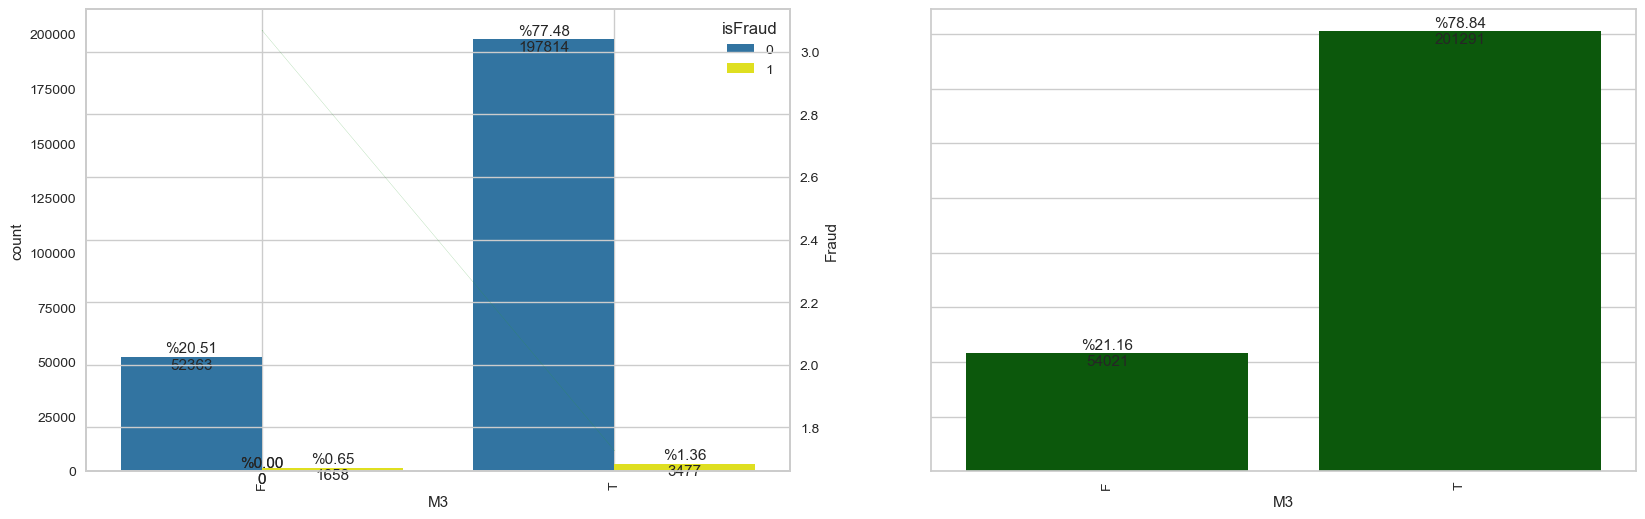

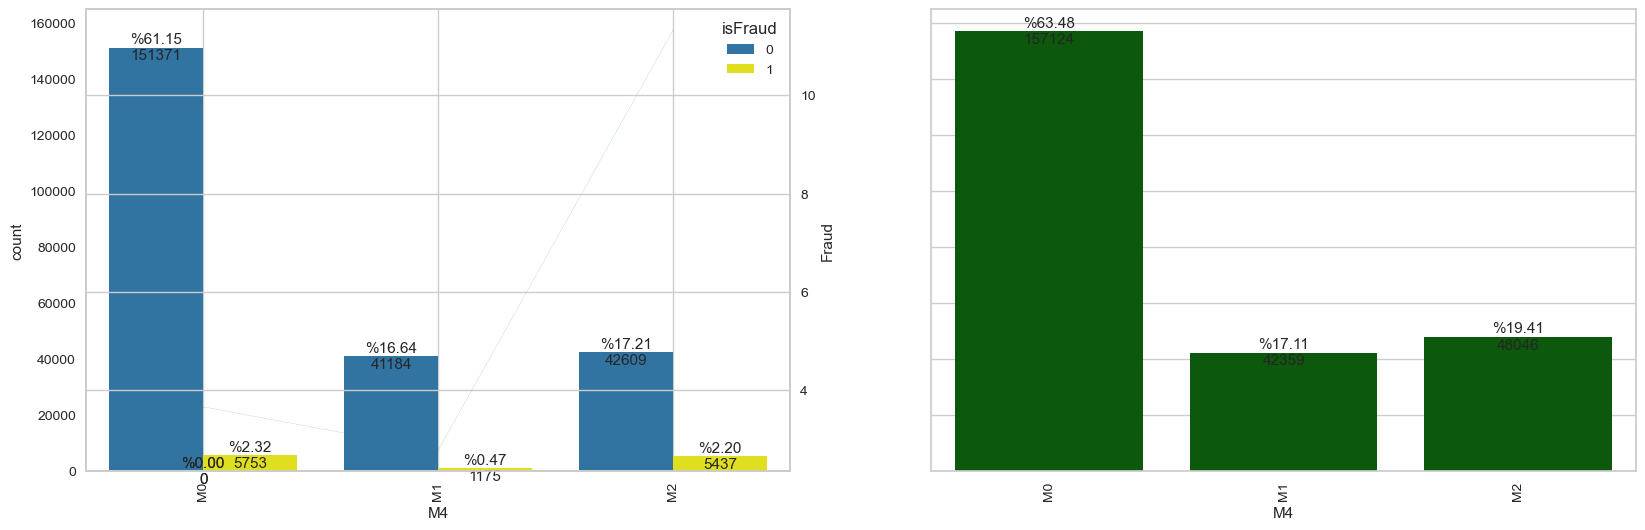

In [57]:
for col in ['M3', 'M4']:
  plot_col(col, df=train1)

In [58]:
# Remplace les NaN par 'undefined' pour les colonnes catégorielles commençant par 'id' ou 'M' suivi d'un chiffre entre 1 et 9
cat_cols = [col for col in train1.columns if col.startswith('id') or re.fullmatch(r'M[1-9]', col)]

# Appliquer uniquement aux colonnes catégorielles
train1[cat_cols] = train1[cat_cols].fillna('undefined')


In [59]:
# Compter les valeurs manquantes parmi M1 à M9 avant remplacement
m_cols = [f'M{i}' for i in range(1, 10)]  # ['M1', 'M2', ..., 'M9']
train1['M_missing_count'] = train1[m_cols].isna().sum(axis=1)


### Product CD, card4 et card6

In [60]:
desc_col(expr='ProductCD', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

ProductCD: object, 5 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : ['C' 'H' 'R' 'S' 'W']



Cette variable ne présente aucune valeur manquante

In [61]:
desc_col(expr='card4', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

card4: object, 4 valeurs uniques, 0.26% de valeurs manquantes
Valeurs uniques : ['american express' 'discover' 'mastercard' 'visa' None]



In [62]:
desc_col(expr='card6', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

card6: object, 4 valeurs uniques, 0.26% de valeurs manquantes
Valeurs uniques : ['charge card' 'credit' 'debit' 'debit or credit' None]



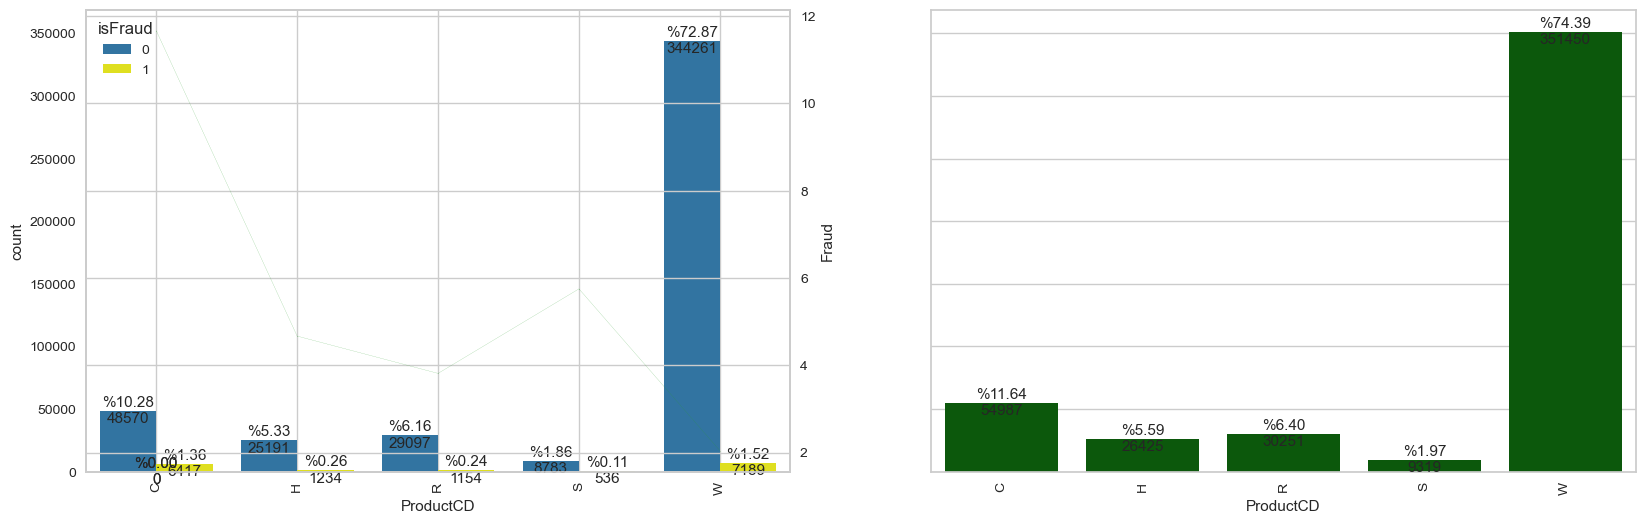

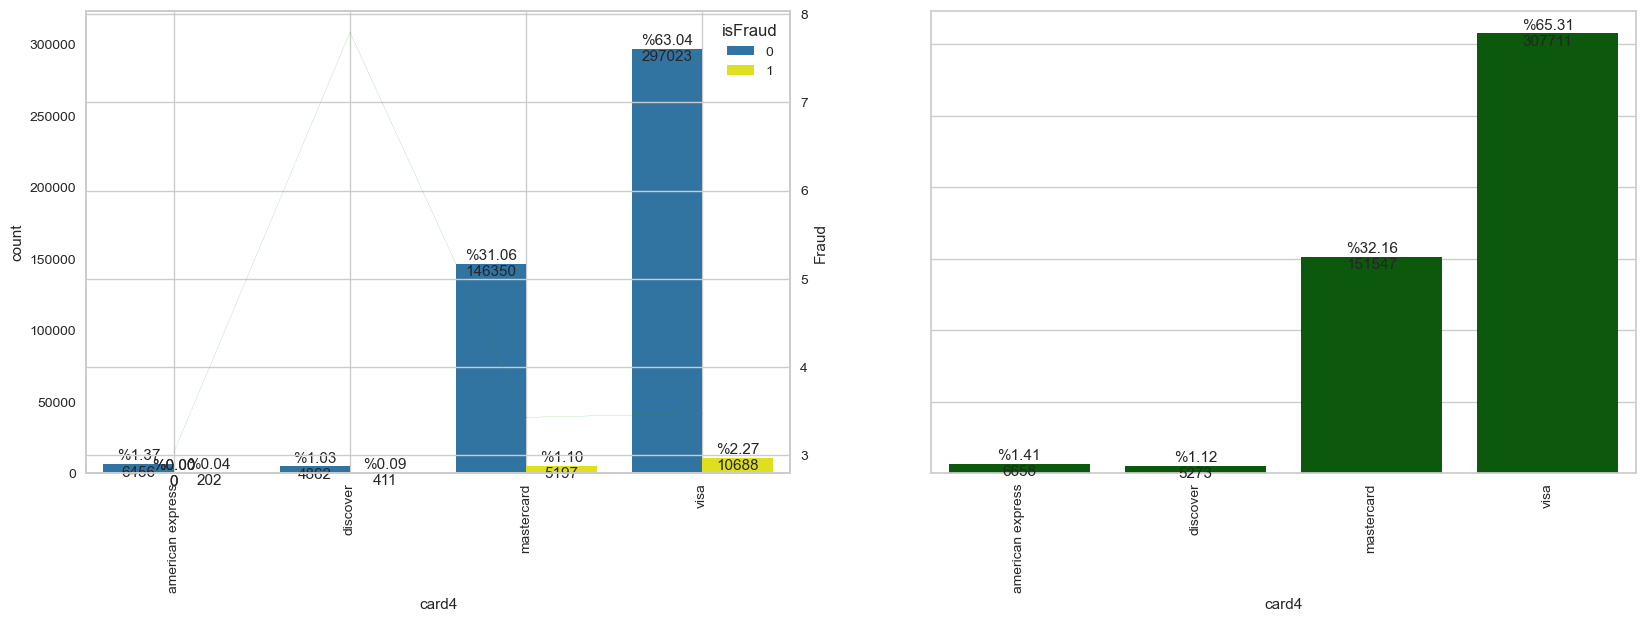

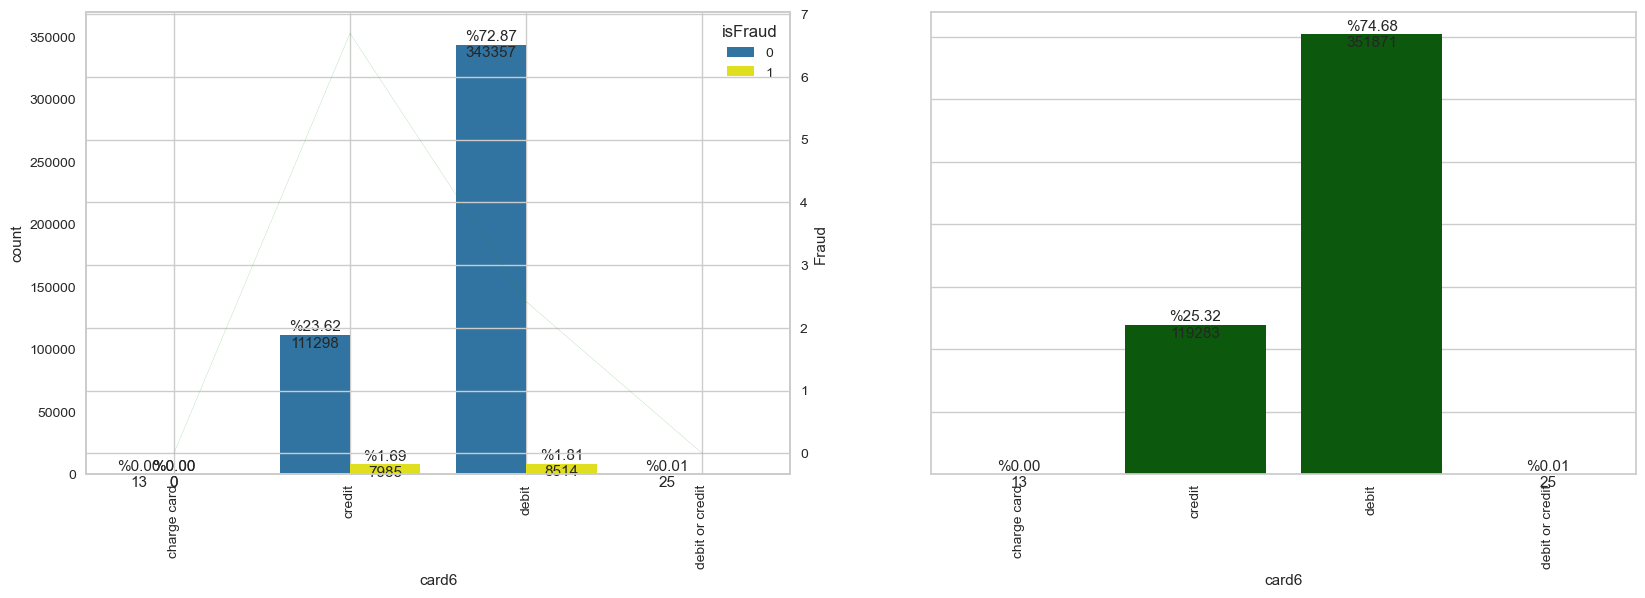

In [63]:
for col in ['ProductCD', 'card4', 'card6']:
  plot_col(col, df=train1)

In [64]:
# Masques booléens des NA
na_card4 = train1['card4'].isna()
na_card6 = train1['card6'].isna()

# Vérifier s'ils sont égaux (ligne par ligne)
same_na_rows = (na_card4 == na_card6)

# Afficher combien de lignes ont les deux NA en même temps
both_na = (na_card4 & na_card6).sum()
print(f"Nombre de lignes où card4 ET card6 sont NA : {both_na}")

# Vérifier si les NA apparaissent exactement aux mêmes lignes
if same_na_rows.all():
    print(" Les lignes avec NA dans card4 sont exactement les mêmes que celles de card6.")
else:
    print(" Les lignes NA dans card4 et card6 ne correspondent pas exactement.")




Nombre de lignes où card4 ET card6 sont NA : 1235
 Les lignes NA dans card4 et card6 ne correspondent pas exactement.


In [65]:
# Imputation par le mode 
for col in ['card4', 'card6']:
    mode_value = train1[col].mode()[0]
    train1[col] = train1[col].fillna(mode_value)


Les % de valeurs manquantes étant faibles, on impute par le mode. 

### Autres variables catégorielles

Les variables suivantes sont catégorielles mais sont codées type en numeriques. 

### Variables commençant par 'card'

In [66]:
desc_col(expr=r'card', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

card1: int64, 12821 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [ 1001  1004  1006 ... 18393 18395 18396]

card2: float64, 500 valeurs uniques, 1.51% de valeurs manquantes
Valeurs uniques : [100. 101. 102. 103. 104. 105. 106. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156.
 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198.
 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226.
 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 

In [67]:
for col in ['card1', 'card2', 'card3', 'card5']:
    train1[col] = train1[col].fillna(train1[col].mode()[0])

In [68]:
for col in ['card1', 'card2', 'card3', 'card5']:
    train1[col] = train1[col]

Ces variables ont très peu de valeurs manquantes, on procède par une imputation par le mode. 

### Variables commençant par addr

In [69]:
desc_col(expr=r'addr', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

addr1: float64, 304 valeurs uniques, 11.16% de valeurs manquantes
Valeurs uniques : [100. 101. 102. 104. 105. 106. 110. 111. 112. 117. 119. 120. 122. 123.
 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 137. 139. 142.
 143. 144. 145. 146. 148. 151. 152. 154. 155. 156. 157. 158. 159. 160.
 161. 162. 163. 164. 166. 167. 168. 170. 171. 172. 174. 177. 180. 181.
 182. 183. 184. 185. 187. 189. 190. 191. 193. 194. 195. 196. 198. 199.
 201. 202. 203. 204. 205. 208. 210. 211. 213. 214. 215. 216. 217. 218.
 219. 220. 221. 224. 225. 226. 231. 233. 234. 235. 236. 237. 238. 239.
 241. 242. 243. 244. 247. 251. 252. 253. 254. 255. 257. 258. 259. 260.
 261. 262. 264. 265. 268. 269. 270. 272. 274. 275. 276. 277. 279. 282.
 283. 284. 286. 290. 292. 294. 295. 296. 297. 298. 299. 300. 301. 303.
 304. 305. 306. 307. 308. 310. 312. 314. 315. 316. 318. 321. 322. 323.
 324. 325. 326. 327. 328. 329. 330. 331. 33

Ces variables representant des informations caractéristiques. La transformation des valeurs manquantes pourrait intrduire des biais : Nous imputons par une valeur significative. 

In [70]:
train1['addr1'] = train1['addr1'].fillna('undefined').astype('category')
train1['addr2'] = train1['addr2'].fillna('undefined').astype('category')

### Analyse des variables numériques 

In [71]:
numeric_vars = train1.select_dtypes(include='number').columns
print(numeric_vars.tolist())

['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'dist1', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V167', 'V168', 'V169', 'V170', 'V171', 'V1

In [72]:
train1[numeric_vars].head(5)

TransactionID  TransactionDT  TransactionAmt  card1  card2  card3  \
40809         3027809        1008491          100.00   6177  399.0  150.0   
285886        3272886        7008212           29.99   7900  345.0  150.0   
104256        3091256        2071522          107.95  11690  111.0  150.0   
507860        3494860       13299752          241.95   2616  327.0  150.0   
196382        3183382        4412283          117.00  13780  298.0  150.0   

        card5  dist1   C1   C2   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
40809   150.0    NaN  1.0  1.0  2.0  0.0  1.0  0.0  2.0  0.0  2.0  1.0  0.0   
285886  224.0    4.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
104256  226.0    NaN  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
507860  102.0    3.0  1.0  2.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
196382  226.0    5.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

         C13  C14     D1     D2    D3     D4    D5    D10    D11    D15   V1  \
40809    2.0  1.0  609.0  609.0   NaN    NaN   NaN    NaN    NaN    NaN  NaN   
285886   0.0  0.0    0.0    NaN   NaN    0.0   NaN    0.0    0.0    0.0  1.0   
104256  15.0  1.0  501.0  501.0  18.0  502.0  18.0  502.0    NaN  502.0  NaN   
507860   4.0  1.0  177.0  177.0  86.0    NaN   NaN  177.0  177.0  177.0  1.0   
196382   2.0  1.0    0.0    0.0   0.0    NaN   NaN    0.0    0.0    0.0  1.0   

         V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  \
40809   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
285886  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
104256  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0   
507860  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0   
196382  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   

        V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
40809   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
285886  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
104256  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
507860  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
196382  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   

        V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  \
40809   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
285886  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
104256  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
507860  1.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
196382  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  \
40809   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
285886  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
104256  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
507860  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0   
196382  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0   

        V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  \
40809   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
285886  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
104256  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0   
507860  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0   
196382  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

        V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  \
40809   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
285886  0.0  0.0  0.0  1

### Variables C1-C14 dist1

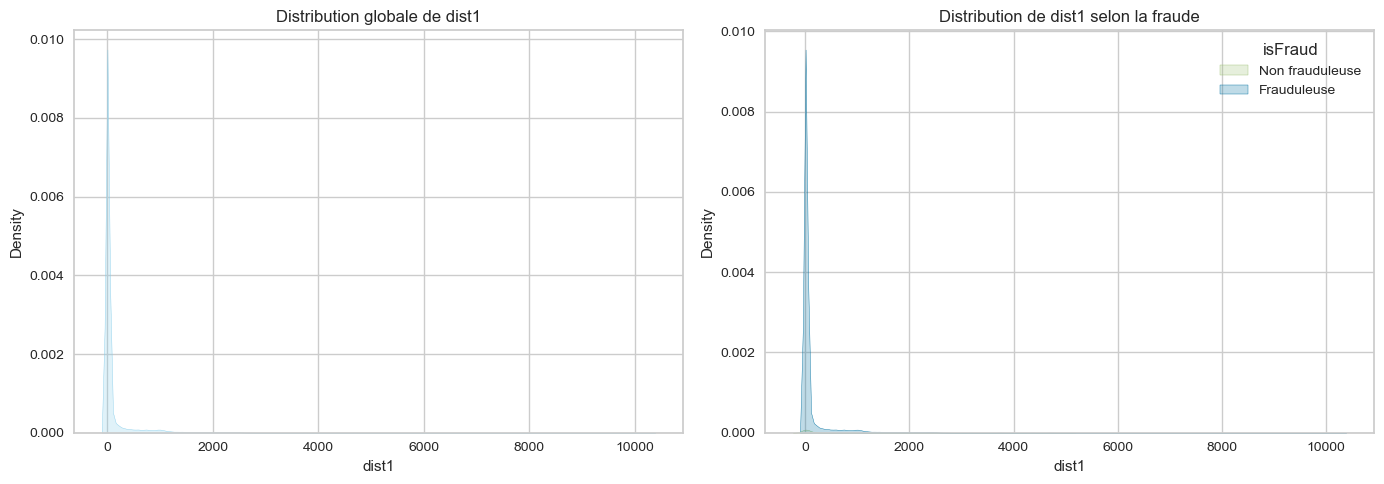

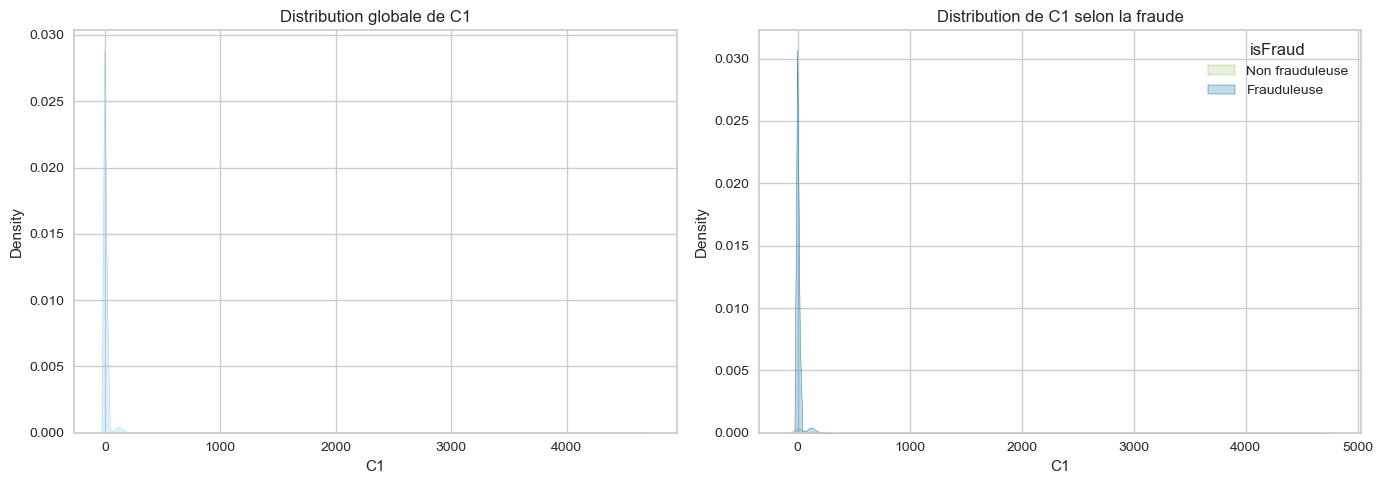

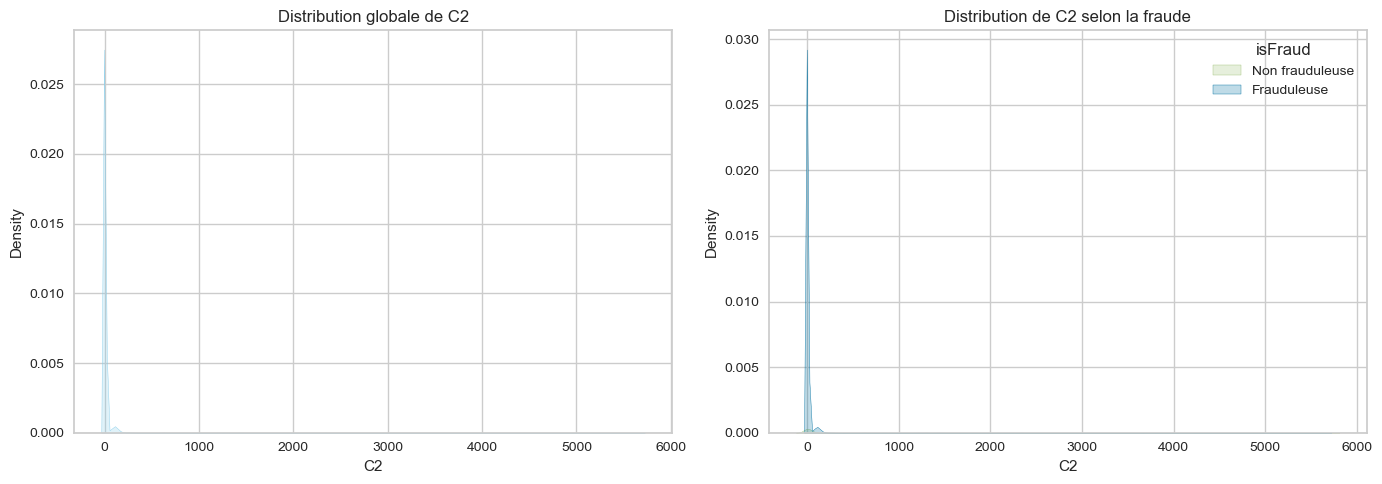

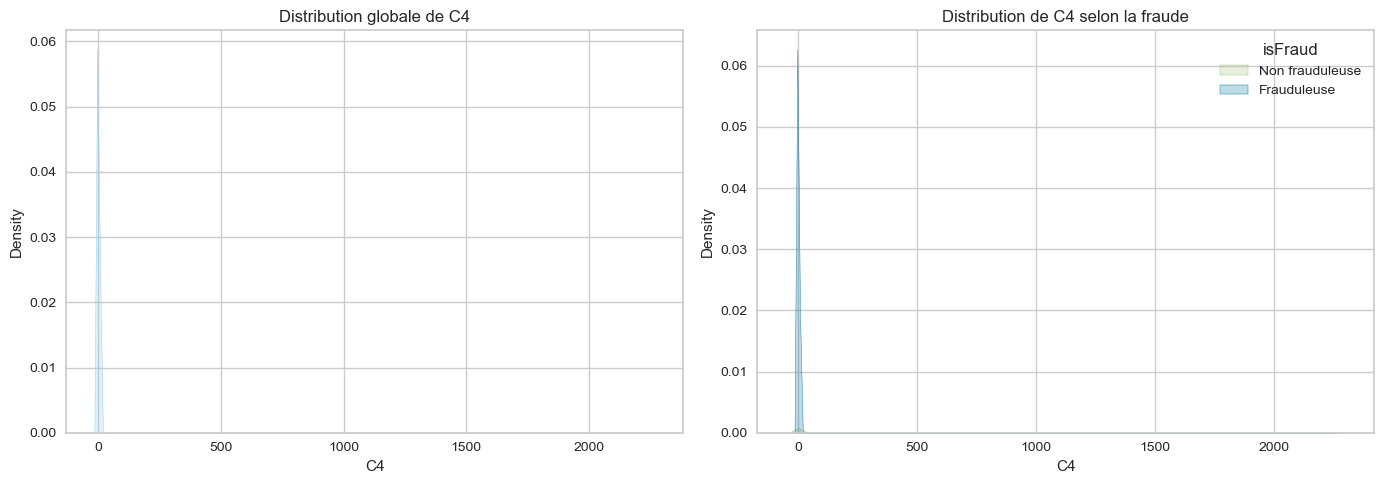

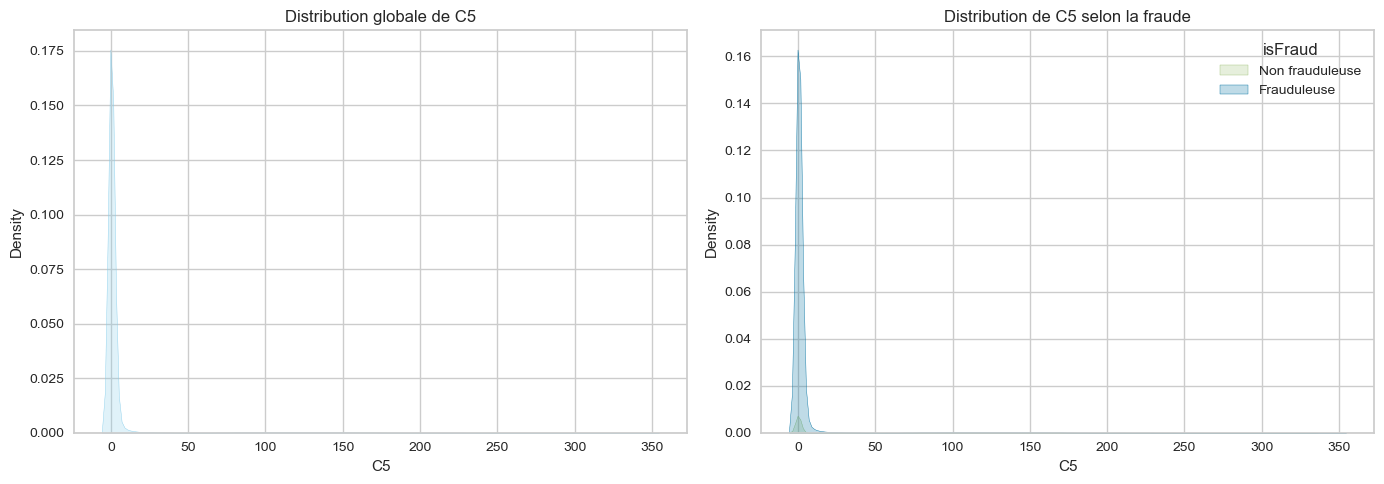

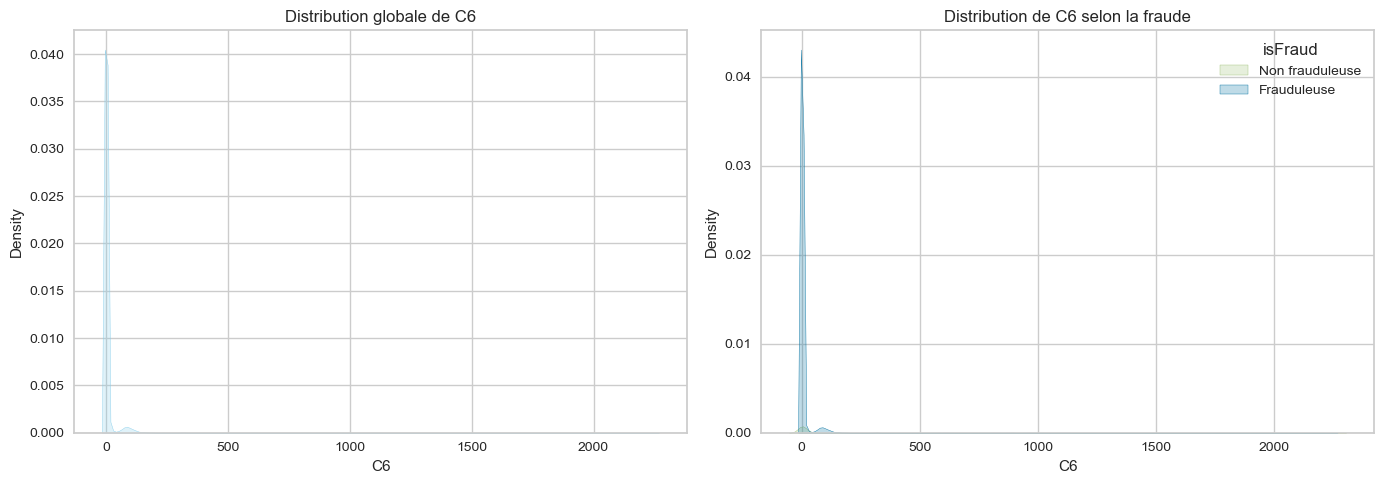

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des variables à visualiser
variables = ['dist1', 'C1', 'C2', 'C4', 'C5', 'C6']

# Boucle sur chaque variable
for var in variables:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Graphique 1 : Distribution globale avec kde
    sns.kdeplot(data=train1, x=var, fill=True, ax=axs[0], color='skyblue')
    axs[0].set_title(f'Distribution globale de {var}')
    axs[0].set_xlabel(var)

    # 2. Graphique 2 : Distribution selon la fraude (isFraud)
    sns.kdeplot(data=train1, x=var, hue='isFraud', fill=True, ax=axs[1])
    axs[1].set_title(f'Distribution de {var} selon la fraude')
    axs[1].set_xlabel(var)
    axs[1].legend(title='isFraud', labels=['Non frauduleuse', 'Frauduleuse'])

    plt.tight_layout()
    plt.show()


La distribution très asymétrique des variables, notamment les C, suggère la présence de valeurs aberrantes. Toutefois, en l'absence d'informations précises sur leur signification, nous avons choisi de ne pas les modifier afin de préserver d'éventuels signaux utiles à la détection de fraude. Par ailleurs, la variable dist1, représentant probablement une distance géographique sera également gardée telle quelle. Cependant nous procederons à une normalisation.

In [74]:
desc_col(expr=r'^C\d', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

C1: float64, 1461 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [0.000e+00 1.000e+00 2.000e+00 ... 4.681e+03 4.682e+03 4.685e+03]

C2: float64, 1127 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [0.000e+00 1.000e+00 2.000e+00 ... 5.625e+03 5.690e+03 5.691e+03]

C4: float64, 1115 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [0.000e+00 1.000e+00 2.000e+00 ... 2.250e+03 2.251e+03 2.253e+03]

C5: float64, 317 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  7

Pas de valeurs manquantes 

### Variables dist1

In [75]:
desc_col(expr='^dist', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

dist1: float64, 2561 valeurs uniques, 59.69% de valeurs manquantes
Valeurs uniques : [0.0000e+00 1.0000e+00 2.0000e+00 ... 8.0810e+03 1.0286e+04        nan]



In [76]:
train1['dist1'] = train1['dist1'].fillna(-1)

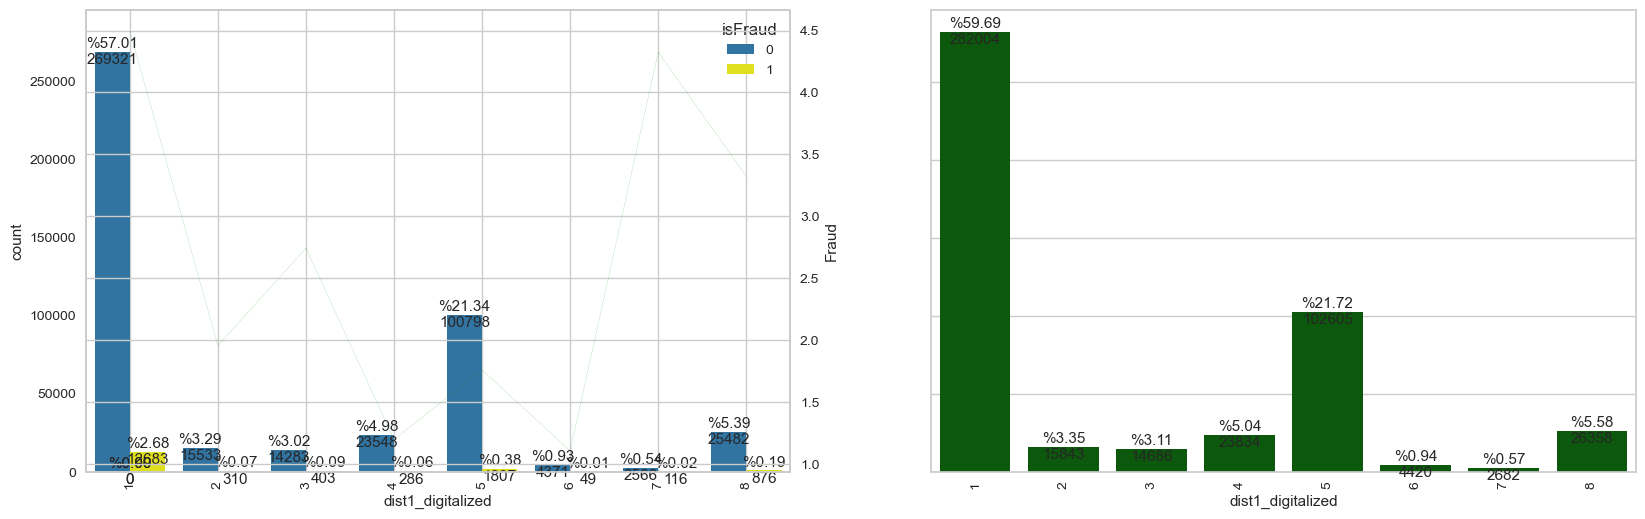

In [77]:
train1['dist1_digitalized'] = pd.Series(
    np.digitize(train1['dist1'].fillna(-1), bins=[-1, 0, 1, 2, 4, 50, 75, 100, 10300]),
    index=train1.index  # pour l'alignement correct
)

plot_col('dist1_digitalized', df=train1)

Cette variable présente énormement de valeurs manquantes. Ces dernières peuvent être informatives Pour éviter les biais, nous les gardons et leur assignons une valeur significative '-1'

### TransactionDT

In [78]:
train1['TransactionDT'].describe()

count    4.724320e+05
mean     7.373394e+06
std      4.616510e+06
min      8.640000e+04
25%      3.028537e+06
50%      7.309639e+06
75%      1.124764e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64

In [79]:
desc_col(expr=r'TransactionDT', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

TransactionDT: int64, 461397 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [   86400    86401    86469 ... 15811079 15811088 15811131]



Cette variable ne contient pas de valeurs manquantes. Nous commençons à y extraires des features.

Nous extrayons ici des features temporelles relatives à partir de la variable TransactionDT, qui représente le temps écoulé depuis un point de départ inconnu. Ces variables permettront d’analyser le comportement des transactions dans le temps, sans dépendre d’une date réelle.
Transaction_day : identifiant du jour relatif de la transaction (jour 0, jour 1, ...).

Transaction_hour : heure relative de la journée (0 à 23) pour observer les comportements horaires.

Transaction_days_since_start : temps écoulé depuis le début du dataset, en jours décimaux.

delta_card1 : temps écoulé depuis la dernière transaction du même utilisateur (card1)

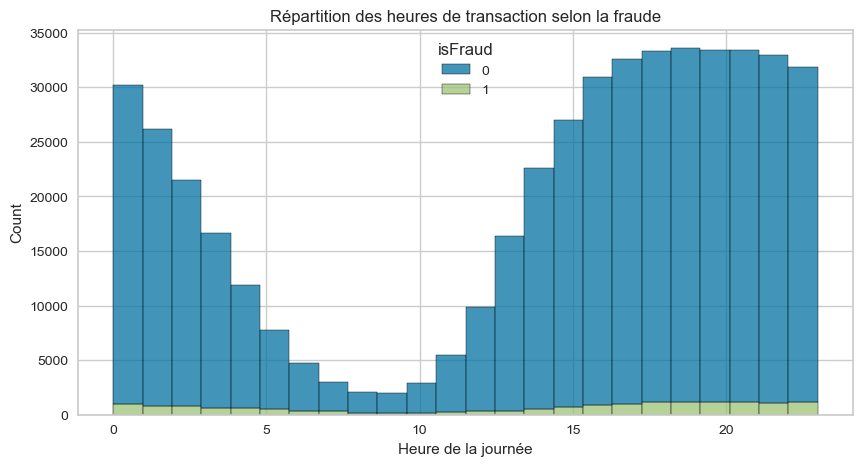

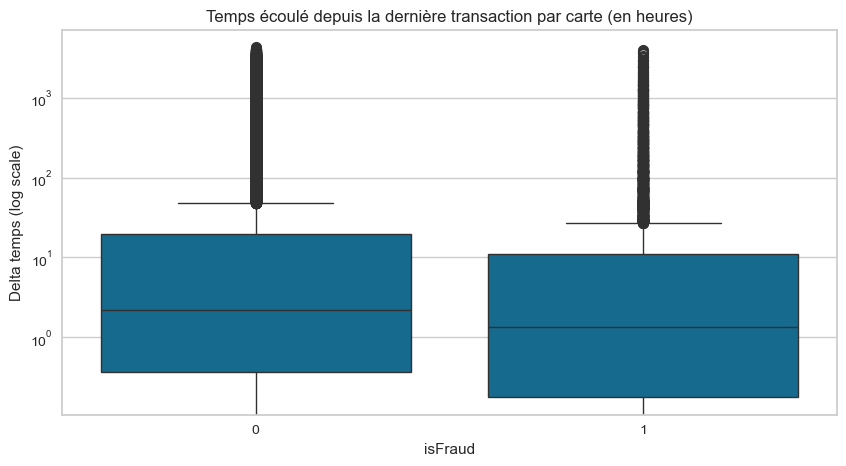

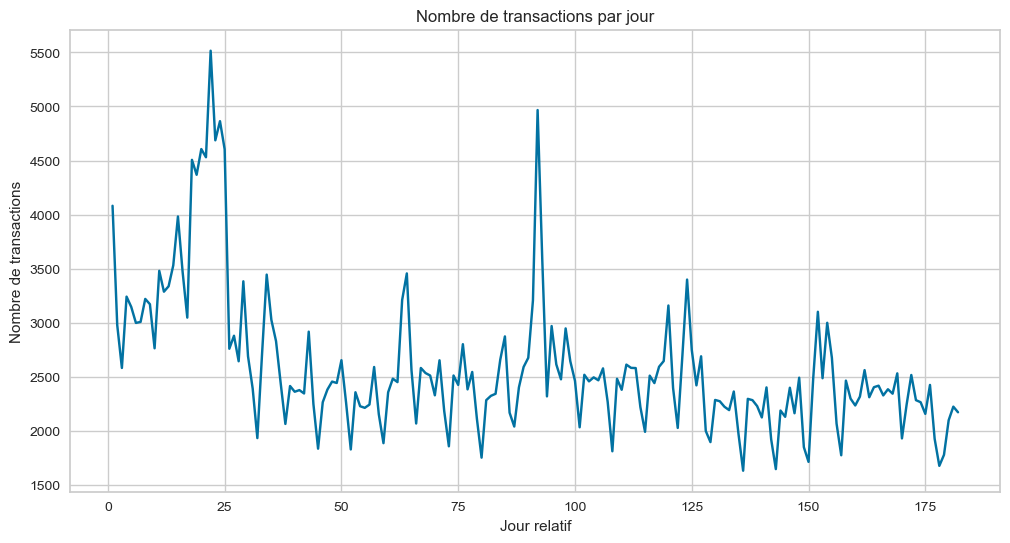

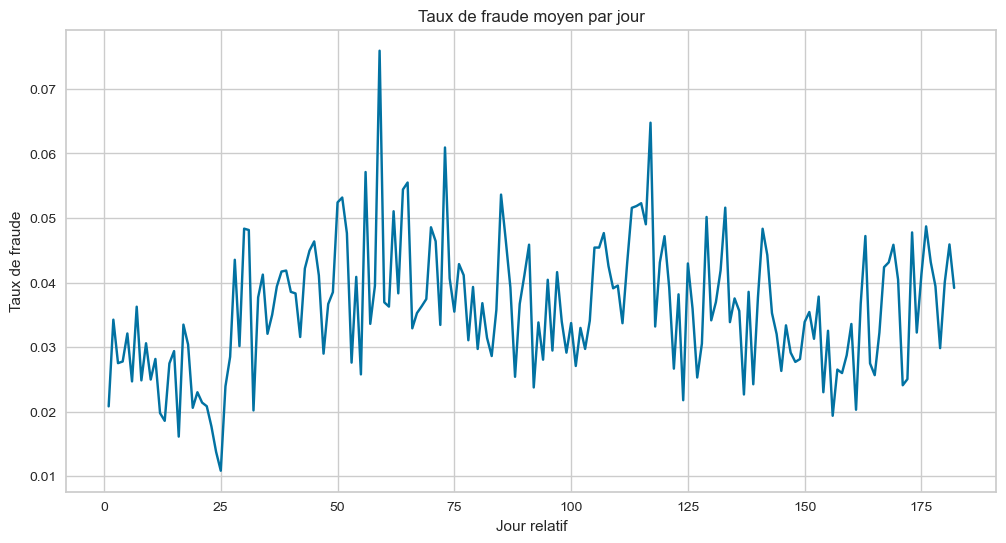

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que 'train' est ton DataFrame principal avec 'TransactionDT', 'TransactionID', 'card1' et 'isFraud'

# 1. Création des variables temporelles
train1['Transaction_day'] = train1['TransactionDT'] // 86400
train1['Transaction_hour'] = (train1['TransactionDT'] % 86400) // 3600
train1['Transaction_days_since_start'] = train1['TransactionDT'] / 86400

# 3. Délai depuis la dernière transaction par carte
train1 = train1.sort_values(['card1', 'TransactionDT'])
train1['delta_card1'] = train1.groupby('card1')['TransactionDT'].diff().fillna(-1) / 3600

# Visualisations

# A. Distribution des heures des transactions selon fraude ou non
plt.figure(figsize=(10, 5))
sns.histplot(data=train1, x='Transaction_hour', hue='isFraud', multiple='stack', bins=24)
plt.title('Répartition des heures de transaction selon la fraude')
plt.xlabel('Heure de la journée')
plt.show()

# B. Temps écoulé depuis dernière transaction par carte selon fraude ou non
plt.figure(figsize=(10, 5))
sns.boxplot(data=train1[train1['delta_card1'] >= 0], x='isFraud', y='delta_card1')
plt.yscale('log')
plt.title('Temps écoulé depuis la dernière transaction par carte (en heures)')
plt.ylabel('Delta temps (log scale)')
plt.show()

# C. Nombre de transactions par jour
plt.figure(figsize=(12, 6))
sns.lineplot(data=train1.groupby('Transaction_day').agg({'isFraud':'mean', 'TransactionID':'count'}).reset_index(),
             x='Transaction_day', y='TransactionID')
plt.title('Nombre de transactions par jour')
plt.xlabel('Jour relatif')
plt.ylabel('Nombre de transactions')
plt.show()

# D. Taux de fraude moyen par jour
plt.figure(figsize=(12, 6))
daily_fraud_rate = train1.groupby('Transaction_day')['isFraud'].mean().reset_index()
sns.lineplot(data=daily_fraud_rate, x='Transaction_day', y='isFraud')
plt.title('Taux de fraude moyen par jour')
plt.xlabel('Jour relatif')
plt.ylabel('Taux de fraude')
plt.show()


### TransactionAmt

In [81]:
desc_col(expr=r'TransactionAmt', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

TransactionAmt: float64, 18621 valeurs uniques, 0.0% de valeurs manquantes
Valeurs uniques : [2.5100000e-01 2.7200000e-01 2.9200000e-01 ... 5.5432300e+03 6.4509700e+03
 3.1937391e+04]



In [82]:
train1['TransactionAmt'] = train1['TransactionAmt'].astype('float32')
print(train1['TransactionAmt'].dtype)  # vérifier le type
print(train1['TransactionAmt'].describe())  # résumé statistique
print(train1[train1['TransactionAmt'] < 0])  # vérifier valeurs négatives (anomalies)
print(train1[train1['TransactionAmt'].isna()])  # vérifier valeurs manquantes


float32
count    472432.000000
mean        135.071747
std         241.388702
min           0.251000
25%          43.139999
50%          68.911003
75%         125.000000
max       31937.390625
Name: TransactionAmt, dtype: float64
Empty DataFrame
Columns: [TransactionID, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, P_emaildomain, R_emaildomain, C1, C2, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D10, D11, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51, V52, V53, V54, V55, ...]
Index: []
Empty DataFrame
Columns: [TransactionID, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, P_emaildomain, R_emaildomain, C1, C2, C4

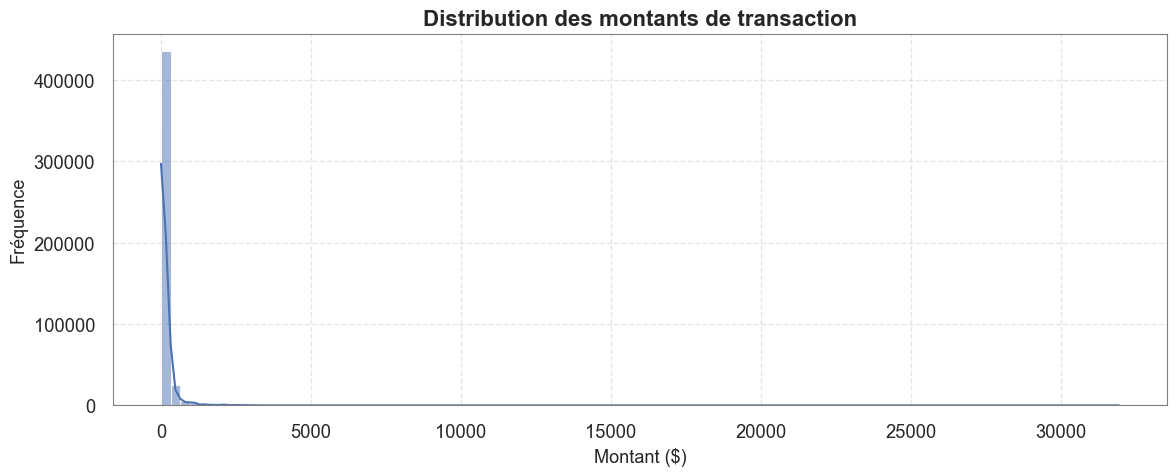

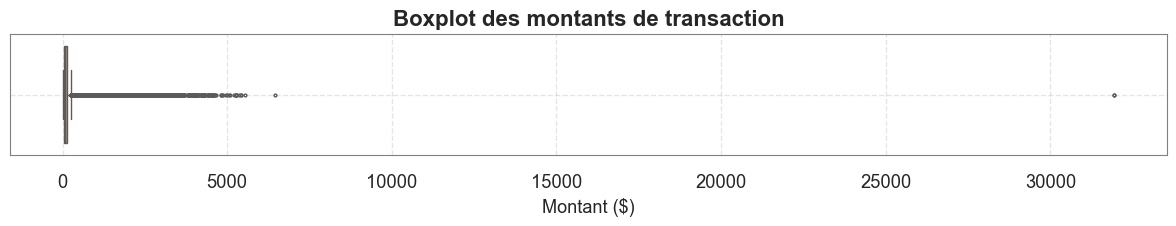

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Appliquer un style clair 
sns.set(style="whitegrid", palette="deep", font="Arial", font_scale=1.2)
plt.rcParams['axes.edgecolor'] = 'gray'
plt.rcParams['axes.linewidth'] = 0.8

# Supprimer les valeurs manquantes
df = train1[train1['TransactionAmt'].notna()]

# Histogramme avec KDE
plt.figure(figsize=(12, 5))
sns.histplot(df['TransactionAmt'], bins=100, kde=True, color="#4C72B0", edgecolor="white")
plt.title('Distribution des montants de transaction', fontsize=16, weight='bold')
plt.xlabel('Montant ($)', fontsize=13)
plt.ylabel('Fréquence', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(12, 2.5))
sns.boxplot(x=df['TransactionAmt'], color="#DD8452", fliersize=2)
plt.title('Boxplot des montants de transaction', fontsize=16, weight='bold')
plt.xlabel('Montant ($)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Cette variable est très asymétriques et présente énormememnt de valeurs abberrantes concentrées dans les montants inférieurs à 5000 ; à partir de 5000 les valeurs sont très dispersées étant donnée que certaines de ces valeurs peuvent être des signes de fraude 

### Variables D1-15

In [84]:
desc_col(expr=r'^D\d.*', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

D1: float64, 641 valeurs uniques, 0.22% de valeurs manquantes
Valeurs uniques : [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 1

In [85]:
cols_D = [f'D{i}' for i in range(1, 16) if f'D{i}' in train1.columns]
train1[cols_D] = train1[cols_D].fillna(999)

### Variables V

In [86]:
# Traitement des variables V1 à V339
Vcols_init = ['V'+str(x) for x in range(1,340)]
Vcols = [col for col in Vcols_init if col in train1.columns]

print(f"Colonnes demandées : {len(Vcols_init)}")
print(f"Colonnes présentes dans train1 : {len(Vcols)}")

train1[Vcols].head()


Colonnes demandées : 339
Colonnes présentes dans train1 : 239


V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
36634   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0   
164336  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
223739  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
33767   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
399444  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  \
36634   0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
164336  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
223739  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
33767   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
399444  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  \
36634   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0   
164336  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0   
223739  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0   
33767   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
399444  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  \
36634   0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0   
164336  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0   
223739  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0   
33767   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
399444  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  \
36634   0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
164336  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
223739  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
33767   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
399444  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  \
36634   0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
164336  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
223739  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
33767   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
399444  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95  V96  V97  V99  \
36634   0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
164336  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   
223739  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
33767   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  0.0  0.0   
399444  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  0.0  0.0   

        V100  V126   V127  V128   V130  V131  V167  V168  V169  V170  V171  \
36634    0.0   0.0    0.0   0.0    0.0   0.0   NaN   NaN   NaN   NaN   NaN   
164336   0.0   0.0  183.0   0.0  183.0   0.0   NaN   NaN   NaN   NaN   NaN   
223739   0.0   0.0    0.0   0.0    0.0   0.0   NaN   NaN   NaN   NaN   NaN   
33767    0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   0.0   1.0   1.0   
399444   0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   0.0   1.0   1.0   

        V172  V173  V174  V175  V176  V177  V178  V179  V180  V181  V182  \
36634    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
164336   NaN   NaN   

On peut remarquer à partir du heatmap que certaines de ces variables sont constituées en groupes de variables très correlées.Nous avons un premier groupe de V1 à V96 environ et un second comprenant le reste. Ces variables peuvent créer des redondances, il est donc essentiel de réduire leur dimensionnalité.

In [87]:
missing_percent = 100 * train1[Vcols].isna().sum() / train1.shape[0]
missing_percent_sorted = missing_percent[missing_percent > 0].sort_values(ascending=False)
print(missing_percent_sorted)

V224    77.852051
V253    77.852051
V249    77.852051
V248    77.852051
V247    77.852051
          ...    
V287     0.001693
V285     0.001693
V280     0.001693
V279     0.001693
V317     0.001693
Length: 239, dtype: float64


Le pourcentage de valeurs manquantes atteint 86,12 % pour certaines variables. Remarquons que certaines variables ont le même % de NA. Nous allons les regrouper pour les étudier en profondeur.

In [88]:
nan_df = train.isna()
nan_groups = {} # dictionary containing colunms with the same sum of nan
for c in Vcols:
    # sum of nan of each columns
    col_sum = nan_df[c].sum()
    if col_sum in nan_groups.keys():
        nan_groups[col_sum].append(c)
    else:
        nan_groups[col_sum] = [c]
del nan_df
print('Il y a ' + str(len(list(nan_groups.keys())))+ ' groupes de variables V contenant le même nombre de valeurs manquantes.')

Il y a 12 groupes de variables V contenant le même nombre de valeurs manquantes.


In [89]:
for key,value in nan_groups.items():
    print('NAN count',key)
    print(value)

NAN count 279287
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
NAN count 76073
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']
NAN count 168969
['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']
NAN count 77096
['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']
NAN count 89164
['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']
NAN count 314
['V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131']
NAN count 450909
['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183', 'V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V2


Groupe 1 : 11 colonnes avec 279287 valeurs manquantes chacune


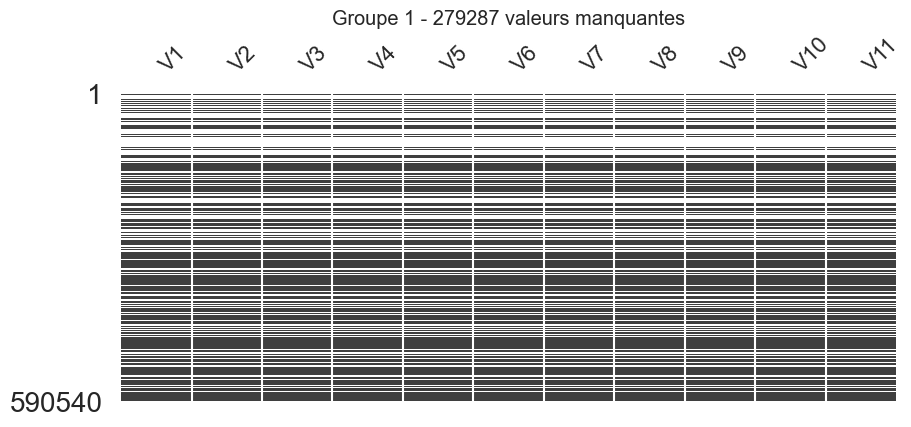


Groupe 2 : 23 colonnes avec 76073 valeurs manquantes chacune


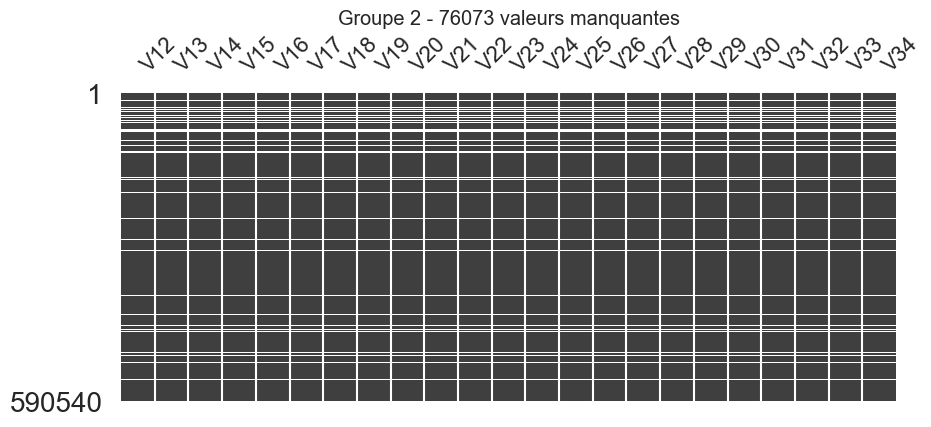


Groupe 3 : 18 colonnes avec 168969 valeurs manquantes chacune


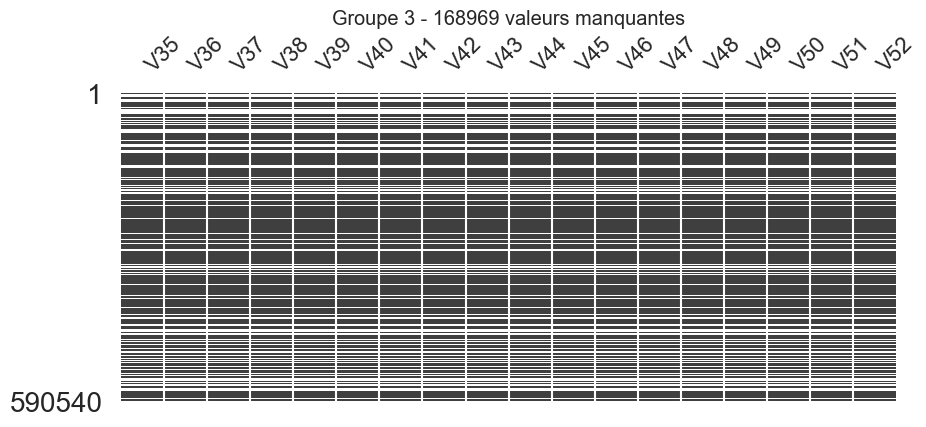


Groupe 4 : 22 colonnes avec 77096 valeurs manquantes chacune


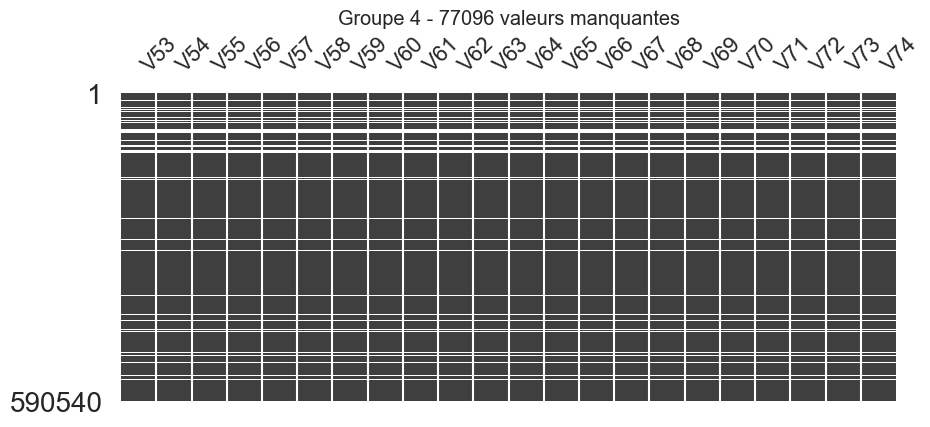


Groupe 5 : 20 colonnes avec 89164 valeurs manquantes chacune


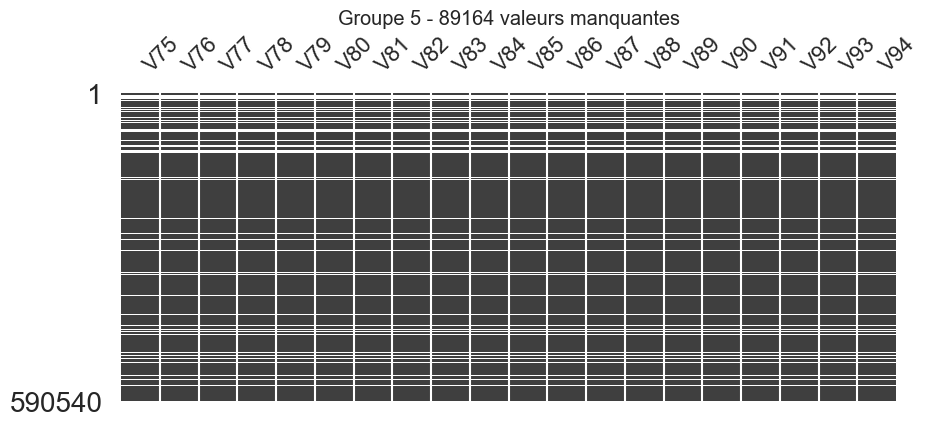


Groupe 6 : 10 colonnes avec 314 valeurs manquantes chacune


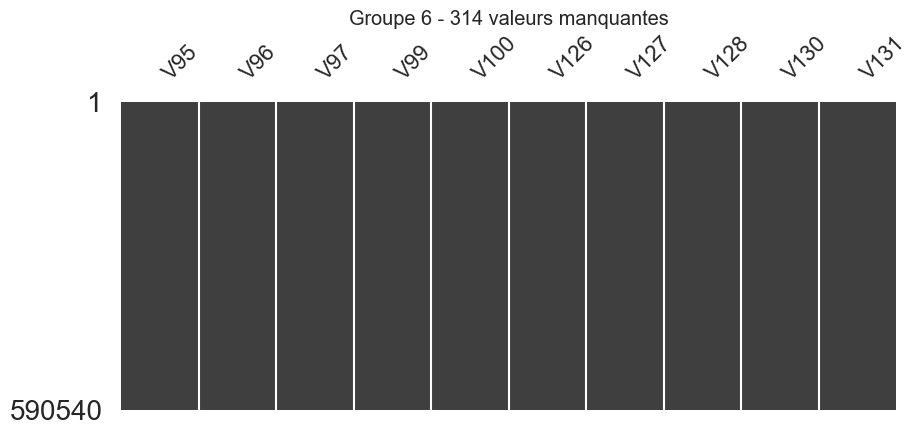


Groupe 7 : 31 colonnes avec 450909 valeurs manquantes chacune


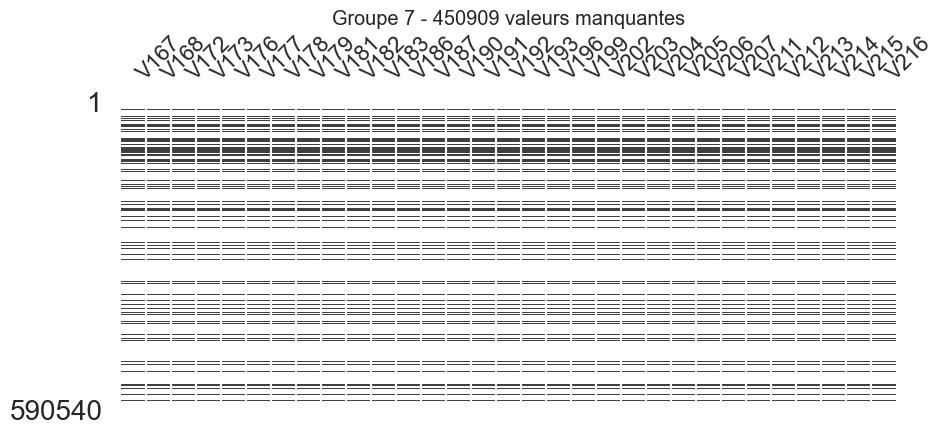


Groupe 8 : 19 colonnes avec 450721 valeurs manquantes chacune


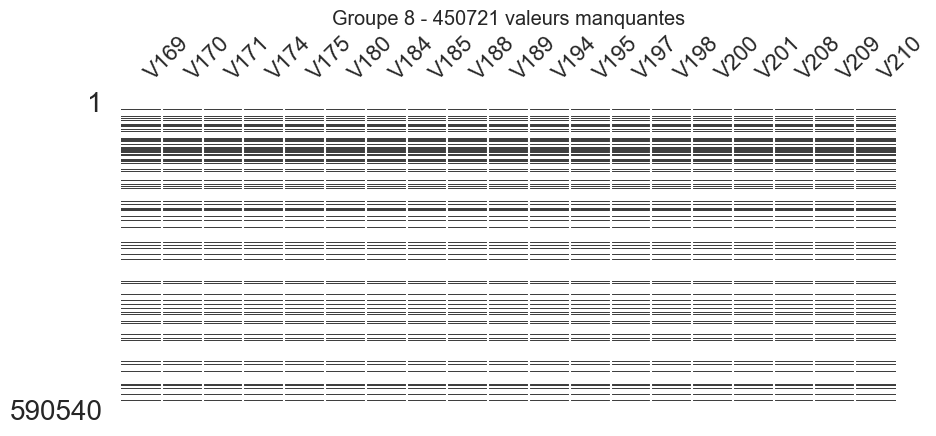


Groupe 9 : 46 colonnes avec 460110 valeurs manquantes chacune


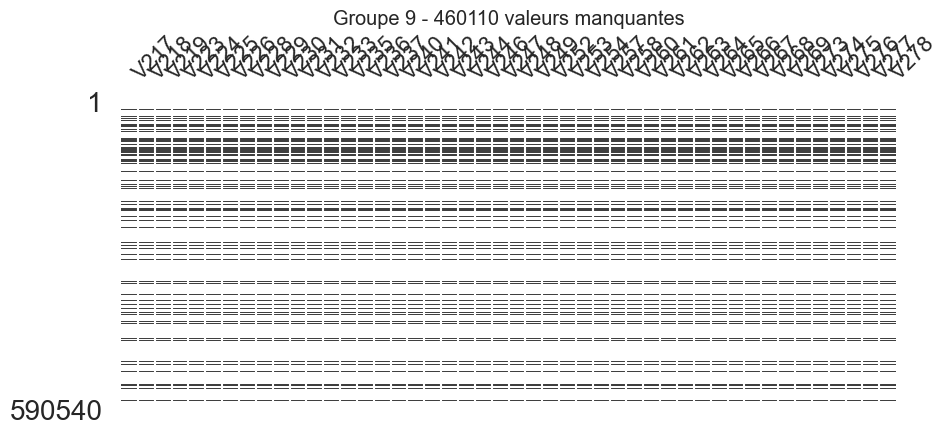


Groupe 10 : 16 colonnes avec 449124 valeurs manquantes chacune


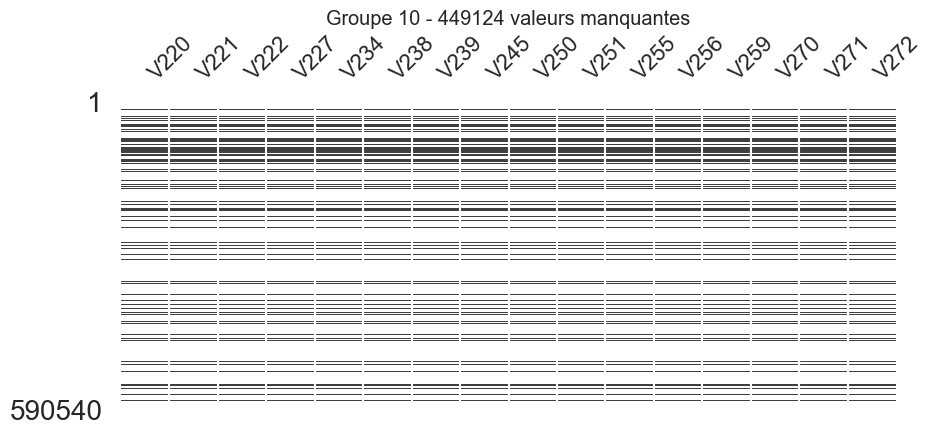


Groupe 11 : 16 colonnes avec 12 valeurs manquantes chacune


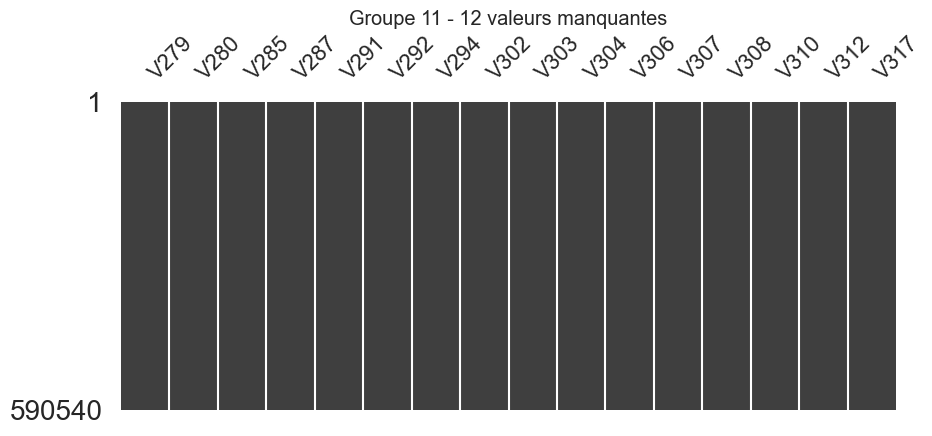


Groupe 12 : 7 colonnes avec 1269 valeurs manquantes chacune


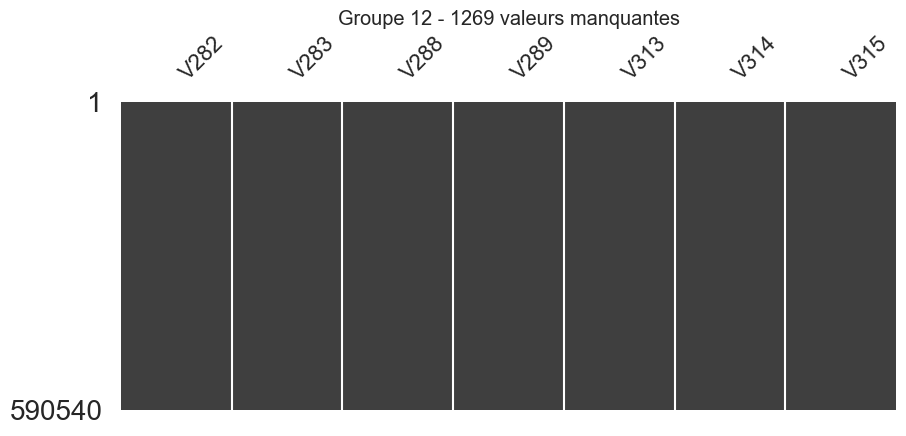

In [90]:
import missingno as msno
import matplotlib.pyplot as plt

# Afficher les graphiques msno.matrix() pour chaque groupe de colonnes
for i, (nan_count, cols) in enumerate(nan_groups.items(), 1):
    if len(cols) < 2:
        continue  # pas la peine d'afficher un graphique pour une seule colonne

    print(f"\nGroupe {i} : {len(cols)} colonnes avec {nan_count} valeurs manquantes chacune")
    msno.matrix(train[cols], sparkline=False, figsize=(10, 4))
    plt.title(f'Groupe {i} - {nan_count} valeurs manquantes')
    plt.show()


Les différents groupes ont non seulement les même pourcentages de valeurs manquantes mais également ces dernières concernent les mêmes lignes.

<Axes: >

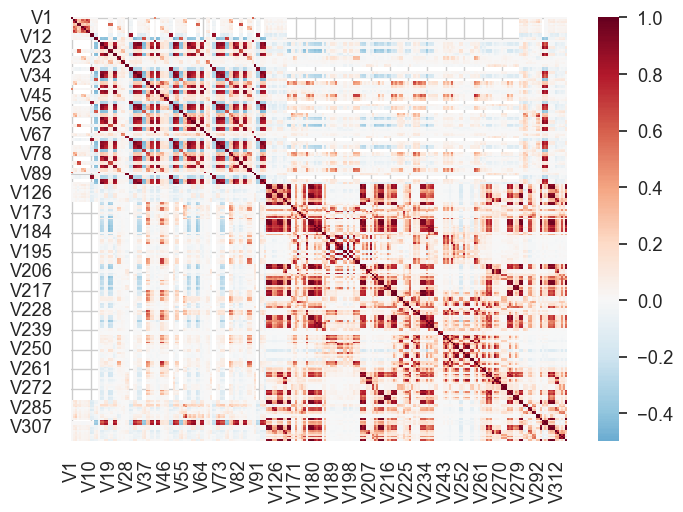

In [91]:
sns.heatmap(train1[Vcols].corr(),cmap = 'RdBu_r',annot=False,center=0.0)

Ces variables semblent correlées. Il faudra effectuer une reduction de dimension. 

In [92]:
desc_col(expr='V', df=train1)

Description des colonnes :
feature: dtype, valeurs uniques, taux de valeurs manquantes (%)

V1: float64, 2 valeurs uniques, 47.34% de valeurs manquantes
Valeurs uniques : [ 0.  1. nan]

V2: float64, 9 valeurs uniques, 47.34% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V3: float64, 10 valeurs uniques, 47.34% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V4: float64, 7 valeurs uniques, 47.34% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6. nan]

V5: float64, 7 valeurs uniques, 47.34% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6. nan]

V6: float64, 10 valeurs uniques, 47.34% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V7: float64, 10 valeurs uniques, 47.34% de valeurs manquantes
Valeurs uniques : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V8: float64, 8 valeurs uniques, 47.34% de valeurs manquantes
Valeurs uniques : [ 0.

In [ ]:
train1[Vcols] = train[Vcols].fillna(-1)

### Vérifications dans la base et importation

In [ ]:
missing_counts = train1.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

In [ ]:
train1

Après traitement global de la base, DeviceInfo, R_emaildomain, DeviceType, P_emaildomain  présentent toujours des valeurs manquantes. Nous avons choisi de ne pas les traiter car elles ne serviront pas directement dans la prédiction. En effet à partir de ces variables, de nouvelles variables ont été crées en prenant en compte leurs valeurs manquantes. Ces dernières ont ensuite été traitées.

In [ ]:
#train1.to_csv("train_fin.csv", index=False)

##### Conclusion de l'EDA-1
Dans le cadre de cette première préparation des données, plusieurs étapes ont été réalisées afin d'améliorer la qualité des variables et de les rendre exploitables pour la modélisation. Les valeurs manquantes ont été traitées de manière adaptée selon le type de variable : par le mode ou par une étiquette explicite ('undefined','uunknown') pour les variables catégorielles ou par le mode / valeur spécifique ('999','-1') pour les variables numériques. Certaines variables ont été transformées (ex. emaildomain, addr1, addr2) afin d’en extraire des composantes plus informatives.
La description et la vraie nature des variables n’étant pas toujours, et dans un contexte de détection de fraude, les valeurs extrêmes peuvant justement contenir des signaux clés, nous avons choisi de préserver les valeurs abberantes. L’objectif a été de préserver au maximum l’information brute tout en rendant les données exploitables par les algorithmes.
Un deuxième traitement consistera à ameliorer cette exploitabilité. 